arXiv (pronounced "archive"—the X represents the Greek letter chi) is an open-access repository of electronic preprints (known as e-prints) approved for posting after moderation, but not full peer review. 

In many fields of mathematics and physics, almost all scientific papers are self-archived on the arXiv repository before publication in a peer-reviewed journal. 

Begun on August 14, 1991, arXiv.org passed the half-million-article milestone on October 3, 2008, and had hit a million by the end of 2014. On August 2020 there are more then 1.7M papers in arXiv repository. 


Although arXiv is not peer reviewed, a collection of moderators for each area review the submissions; they may recategorize any that are deemed off-topic, or reject submissions that are not scientific papers, or sometimes for undisclosed reasons. See [https://arxiv.org/help/moderation](https://arxiv.org/help/moderation) 

The lists of moderators of arXiv are publicly available [here](https://arxiv.org/moderators/).

source: [wikipedia](https://en.wikipedia.org/wiki/ArXiv)


In this notebook I explore and visualize the arXiv taxonomy and the most influential articles in various arXiv fields over the years, counting the citations of each paper to the other papers on arXiv

# Preprocess data and utility functions

In [3]:
!pip install seaborn

In [8]:
!pip install gsutil

  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Created wheel for gsutil: filename=gsutil-5.5-py3-none-any.whl size=3715999 sha256=7d091a8b37db3a1fa3abfa76e2c265955458aebd210c8d3179c824f19e933acf
  Stored in directory: c:\users\krajarat\appdata\local\pip\cache\wheels\01\7f\60\a5d4494eefa59d2bfb712df237a05bd6f27e49bd6b4bd59cd5
  Created wheel for crcmod: filename=crcmod-1.7-py3-none-any.whl size=18838 sha256=c1366834bbf0c58736e48bf0143fc058fd16c6e6dc9b2859bc27105a77a0c840
  Stored in directory: c:\users\krajarat\appdata\local\pip\cache\wheels\ca\5a\02\f3acf982a026f3319fb3e798a8dca2d48fafee7761788562e9
  Created wheel for gcs-oauth2-boto-plugin: filename=gcs_oauth2_boto_plugin-3.0-py3-none-any.whl size=23204 sha256=c967c8863ac821e61565af4cc3c0f1274bf06c7343367d79375c89cf5f749ab1
  Stored in directory: c:\users\krajarat\appdata\local\pip\cache\wheels\c2\ff\00\10b8

In [26]:
!pip install networkx

  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)


In [1]:
from pathlib import Path
project_dir = Path(".").resolve().parents[0]

In [5]:
project_dir

WindowsPath('C:/Users/krajarat/Code/mathjobs')

In [ ]:
!gsutil cp gs://arxiv-dataset/metadata-v5/arxiv-metadata-oai.json ../data/raw/archive

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  json

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import seaborn as sns

#from wordcloud import WordCloud, STOPWORDS


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

METADATA_PATH = project_dir / "data/raw/archive/arxiv-metadata-oai-snapshot.json" #"/kaggle/input/arxiv/arxiv-metadata-oai-snapshot-2020-08-14.json"        
        
#!gsutil cp gs://arxiv-dataset/metadata-v5/internal-citations.json ../data/raw/archive

In [396]:
%%time
## create a metadata citation csv

with open( (project_dir / "data/raw/archive/internal-citations.json")) as f:
    citations = json.load(f)

with open(project_dir / "data/raw/archive/arxiv-metadata-ext-citation.csv","w+") as f_out :
    f_out.write("id,id_reference\n")
    for i,id in enumerate(citations):
        for k in citations[id]:
            f_out.write(f'{id},{k}\n')
                
df_citations = pd.read_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-citation.csv",dtype={"id":object,"id_reference":object})
df_citations.head()

Wall time: 34 s


,id,id_reference
0,hep-lat/0403007,hep-lat/0209117
1,hep-lat/0403007,hep-lat/0005023
2,hep-lat/0403007,hep-ph/9805389
3,hep-lat/0403007,hep-ph/0311130
4,hep-lat/0403007,hep-ph/9511397


In [409]:
%%time
## create a metadata category csv

with open(project_dir / "data/raw/archive/arxiv-metadata-ext-category.csv","w+") as f_out :
    f_out.write("id,category_id\n")


    with open(METADATA_PATH) as f_in:
        for i,line in enumerate(f_in):
            row = json.loads(line)
            id = row["id"]
            categories = row["categories"].split()
            for c in categories:
                f_out.write ( f'"{id}","{c}"\n'  )
                
df_categories = pd.read_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-category.csv",dtype={'id': object})
df_categories.head()                                     

Wall time: 41.4 s


,id,category_id
0,0704.0001,hep-ph
1,0704.0002,math.CO
2,0704.0002,cs.CG
3,0704.0003,physics.gen-ph
4,0704.0004,math.CO


In [407]:
cnt = 0
with open(METADATA_PATH) as f_in:
    for i,line in enumerate(f_in):
        if cnt == 5:
            break
        cnt += 1
        row = json.loads(line)
        id = row["id"]
        categories = row["categories"]
        print(categories)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [398]:
%%time
## create a metadata paper csv

titles = []
abstracts = []
ids = []
authors = []
journal_refs = []

with open(METADATA_PATH) as f_in:
    for i,line in enumerate(f_in):
        row = json.loads(line)

        titles.append(row["title"])
        abstracts.append(row["abstract"])
        ids.append(row["id"])
        authors.append(row["authors"]) 
        journal_refs.append(row["journal-ref"])
        
df_papers = pd.DataFrame({
    'id' : ids,
    'title' : titles,
    'abstract' : abstracts,
    'authors' : authors,
    'journal-ref' : journal_refs
    
})
df_papers.to_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-paper.csv", index=False)
df_papers.head()        

Wall time: 1min 29s


,id,title,abstract,authors,journal-ref
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","Phys.Rev.D76:013009,2007"
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,None
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,Hongjun Pan,None
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,David Callan,None
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"Illinois J. Math. 52 (2008) no.2, 681-689"


In [399]:
%%time
## create a metadata version csv
with open(project_dir / "data/raw/archive/arxiv-metadata-ext-version.csv","w+") as f_out :
    f_out.write("id,version,created\n")

    with open(METADATA_PATH) as f_in:
        for i,line in enumerate(f_in):
            row = json.loads(line)
            id = row["id"]
            versions = row["versions"]
            for v in versions:
                f_out.write (f'{id},{v["version"]},\"{v["created"]}\"\n')

df_versions = pd.read_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-version.csv",dtype={'id': object})
df_versions.head()                     

Wall time: 43.3 s


,id,version,created
0,0704.0001,v1,"Mon, 2 Apr 2007 19:18:42 GMT"
1,0704.0001,v2,"Tue, 24 Jul 2007 20:10:27 GMT"
2,0704.0002,v1,"Sat, 31 Mar 2007 02:26:18 GMT"
3,0704.0002,v2,"Sat, 13 Dec 2008 17:26:00 GMT"
4,0704.0003,v1,"Sun, 1 Apr 2007 20:46:54 GMT"


In [394]:
cnt = 0
with open(METADATA_PATH) as f_in:
    for i,line in enumerate(f_in):
        if cnt == 2:
            break
        cnt += 1
        row = json.loads(line)
        print(row)

{'id': '0704.0001', 'submitter': 'Pavel Nadolsky', 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan", 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'comments': '37 pages, 15 figures; published version', 'journal-ref': 'Phys.Rev.D76:013009,2007', 'doi': '10.1103/PhysRevD.76.013009', 'report-no': 'ANL-HEP-PR-07-12', 'categories': 'hep-ph', 'license': None, 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab

In [400]:
%%time
## add datetime year and month to create field
df_versions["created"] = pd.to_datetime(df_versions["created"]) 
df_versions["year"] = df_versions["created"].dt.year
df_versions["month"] = df_versions["created"].dt.month

df_versions.to_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-version.csv", index=False)

Wall time: 7min 18s


In [640]:
def count_by_category_and_year(group_name):
    cats = df_categories.merge(df_taxonomy, on="category_id").query("group_name == @group_name").merge(df_versions.query("version =='v1'")[["id","year"]], on ="id") 
    cats = cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id") 
    return cats

def count_by_archive_and_year(group_name):
    cats = df_categories.merge(df_taxonomy, on="category_id").query("group_name == @group_name").merge(df_versions.query("version =='v1'")[["id","year"]], on ="id") 
    cats = cats.groupby(["year","archive_name"]).count().reset_index().pivot(index="archive_name", columns="year",values="id") 
    return cats


def show_count_by_category_and_year(group_name,figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.title(f"{group_name} papers by category and year")
    sns.heatmap(count_by_category_and_year(group_name),cmap="Greens", linewidths=0.01, linecolor='palegreen')
    plt.show()

def show_count_by_archive_and_year(group_name="Physics",figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.title(f"{group_name} papers by archive and year")
    sns.heatmap(count_by_archive_and_year(group_name),cmap="Greens", linewidths=0.01, linecolor='palegreen')
    plt.show()
    
def top_k_influential (group_name, top_k=3, threshold=10):
    ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name.isin(@group_name)", engine="python")["id"].values
    cits = df_citations.query( 'id.isin(@ids)', engine="python" ).merge( df_versions.query("version == 'v1'")[["id","year"]], on ="id").groupby(["year","id_reference"]).count()
    cits = cits.reset_index()
    cits = cits.loc[cits.groupby('year')['id'].nlargest(top_k).reset_index()['level_1']]
    cits = cits.query ( "id > @threshold" )
    cits = cits.rename(columns={"id":"references", "id_reference":"id"})
    cits = cits.merge(df_papers,on="id")
    
    return cits

def show_influential_heatmap (group_name, cits, figsize=(10,25)):
    hm_cits =  cits.pivot(index="title", columns="year",values="references")     

    plt.figure(figsize=figsize)
    plt.title("Top influential papers by year")
    sns.heatmap(hm_cits,cmap="Greens", linewidths=0.01, linecolor='palegreen')
    plt.show()

def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)
    
    
def show_influential_table ( cits):
    df = cits.groupby(["id","title","authors","abstract"]).agg({"references":"sum"}).reset_index()
    df = df.sort_values(by="references",ascending = False).reset_index(drop=True)
    df ["url"] = df["id"].map(lambda x:  f'https://arxiv.org/pdf/{x}' ) 
    df ["authors"] = df["authors"].map(lambda x: x if len(str(x)) < 50 else str(x)[:47] + "..." )

    df =df [["title","authors","abstract","url","references"]]
    return df.style.format({'url': make_clickable})


# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'We', 'paper', 'new'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask,
                    min_word_length = 4,
                    #normalize_plurals = True, 
                    #collocations = True,      
                    #collocation_threshold = 10      
                         )
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


# Taxonomy And Top Influential Papers


arXiv consists of scientific papers [categorized in the fields of these groups](https://arxiv.org/category_taxonomy) 

* Computer Science
* Economics
* Electrical Engineering and Systems Science
* Mathematics
* Physics
* Quantitative Biology
* Quantitative Finance
* Statistics

Each group is in turn subdivided into different categories and - for Physics group - in different archives.

In [414]:
## load taxonomy from https://arxiv.org/category_taxonomy
website_url = requests.get('https://arxiv.org/category_taxonomy').text
soup = BeautifulSoup(website_url,'lxml')

root = soup.find('div',{'id':'category_taxonomy_list'})

tags = root.find_all(["h2","h3","h4","p"], recursive=True)

level_1_name = ""
level_2_code = ""
level_2_name = ""

level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw)
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'category_id' : level_3_codes,
    'category_description': level_3_notes
    
})
df_taxonomy.to_csv(project_dir / "data/raw/archive/arxiv-metadata-ext-taxonomy.csv", index=False)
df_taxonomy.groupby(["group_name","archive_name"]).head(3)

,group_name,archive_name,archive_id,category_name,category_id,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
40,Economics,Economics,Economics,Econometrics,econ.EM,"Econometric Theory, Micro-Econometrics, Macro-..."
41,Economics,Economics,Economics,General Economics,econ.GN,"General methodological, applied, and empirical..."
42,Economics,Economics,Economics,Theoretical Economics,econ.TH,Includes theoretical contributions to Contract...
43,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Audio and Speech Processing,eess.AS,Theory and methods for processing signals repr...
44,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Image and Video Processing,eess.IV,"Theory, algorithms, and architectures for the ..."
45,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,Signal Processing,eess.SP,"Theory, algorithms, performance analysis and a..."
47,Mathematics,Mathematics,Mathematics,Commutative Algebra,math.AC,"Commutative rings, modules, ideals, homologica..."


In [403]:
df_categories

,id,category_id
0,0704.0001,h
1,0704.0001,e
2,0704.0001,p
3,0704.0001,-
4,0704.0001,p
...,...,...
29524070,supr-con/9609004,r
29524071,supr-con/9609004,-
29524072,supr-con/9609004,c
29524073,supr-con/9609004,o


In [404]:
group_name=["Mathematics", "Computer Science"]
df_categories.merge(df_taxonomy, on="category_id").query("group_name.isin(@group_name)", engine="python")["id"].values

array([], dtype=object)

In [333]:
df

,year,month,id,tot
16,1991,1991-1,10,44
17,1991,1991-2,3,47
18,1991,1991-3,3,50
19,1991,1991-4,4,54
20,1991,1991-5,3,57
...,...,...,...,...
378,2021,2021-3,16794,1862020
379,2021,2021-4,15073,1877093
380,2021,2021-5,15205,1892298
381,2021,2021-6,16172,1908470


In [334]:
df_versions

,id,version,created,year,month
2958760,physics/9403001,v1,1986-04-25 15:39:49+00:00,1986,4
2791833,hep-th/9108028,v1,1988-11-11 15:39:49+00:00,1988,11
2901461,math/9201239,v1,1989-04-15 00:00:00+00:00,1989,4
2901420,math/9201203,v1,1989-10-26 14:59:00+00:00,1989,10
2901421,math/9201204,v1,1989-10-26 14:59:00+00:00,1989,10
...,...,...,...,...,...
2395408,2107.07508,v1,2021-07-15 17:59:08+00:00,2021,7
2395409,2107.07509,v1,2021-07-15 17:59:10+00:00,2021,7
2395410,2107.07510,v1,2021-07-15 17:59:33+00:00,2021,7
2395411,2107.07511,v1,2021-07-15 17:59:50+00:00,2021,7


C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



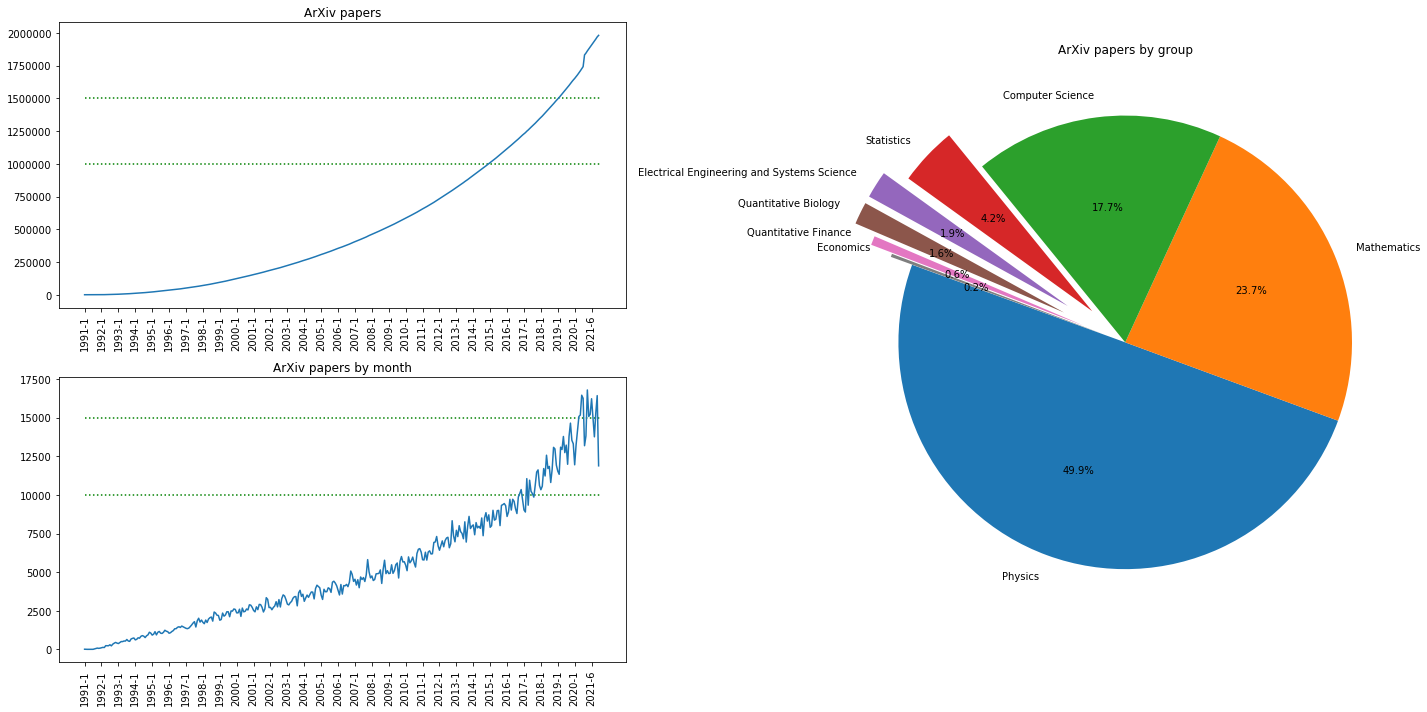

In [532]:
df = df_versions.query("version =='v1'").groupby(["year","month"]).agg({"id":'count'}).reset_index()
df["tot"] = df["id"].cumsum()

df = df.query("year > 1990 and ( year != 2020 or month < 8)")
df["month"] =  df["year"].astype(str) + "-" + df["month"].astype(str)  


_df = df_categories.merge(df_taxonomy, on="category_id", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

fig = plt.figure(figsize=(20,10))


ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.title.set_text('ArXiv papers')
ax1.plot(df["month"], df["tot"])
ax1.hlines(y=1e6, xmin=0, xmax=len(df), color='green', linestyle="dotted")
ax1.hlines(y=1.5e6, xmin=0, xmax=len(df), color='green', linestyle="dotted")
ax1.set_xticks(np.arange(0, len(df), 12.0))
ax1.tick_params('x',labelrotation=90)


ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.title.set_text("ArXiv papers by month")
ax2.plot(df["month"], df["id"])
ax2.hlines(y=10000, xmin=0, xmax=len(df), color='green', linestyle="dotted")
ax2.hlines(y=15000, xmin=0, xmax=len(df), color='green', linestyle="dotted")
ax2.set_xticks(np.arange(0, len(df), 12.0))
ax2.tick_params('x',labelrotation=90)

ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.title.set_text("ArXiv papers by group")
explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2, 0.1) 
ax3.pie(_df["id"],  labels=_df["group_name"], autopct='%1.1f%%', startangle=160, explode=explode)


plt.tight_layout()
plt.show()




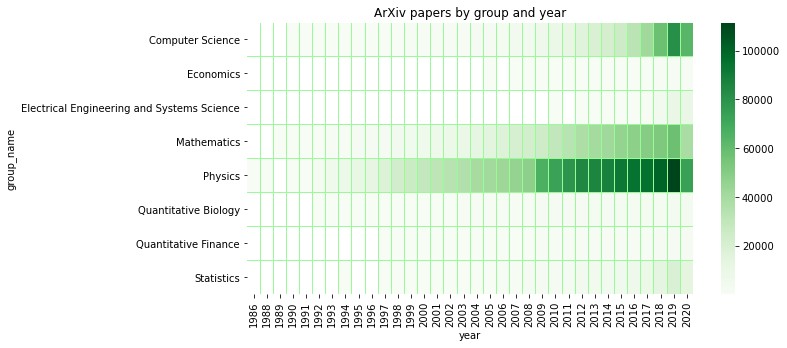

In [10]:
cats = df_categories.merge(df_taxonomy, on="category_id").merge(df_versions.query("version =='v1'")[["id","year"]], on ="id") 
cats = cats.groupby(["year","group_name"]).count().reset_index().pivot(index="group_name", columns="year",values="id") 

plt.figure(figsize=(10,5))
plt.title("ArXiv papers by group and year")
sns.heatmap(cats,cmap="Greens", linewidths=0.01, linecolor='palegreen')
plt.show()



## Physics

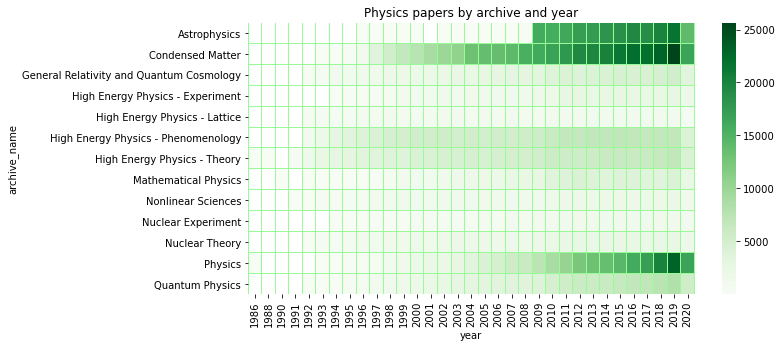

In [11]:
group_name="Physics"
show_count_by_archive_and_year(group_name)

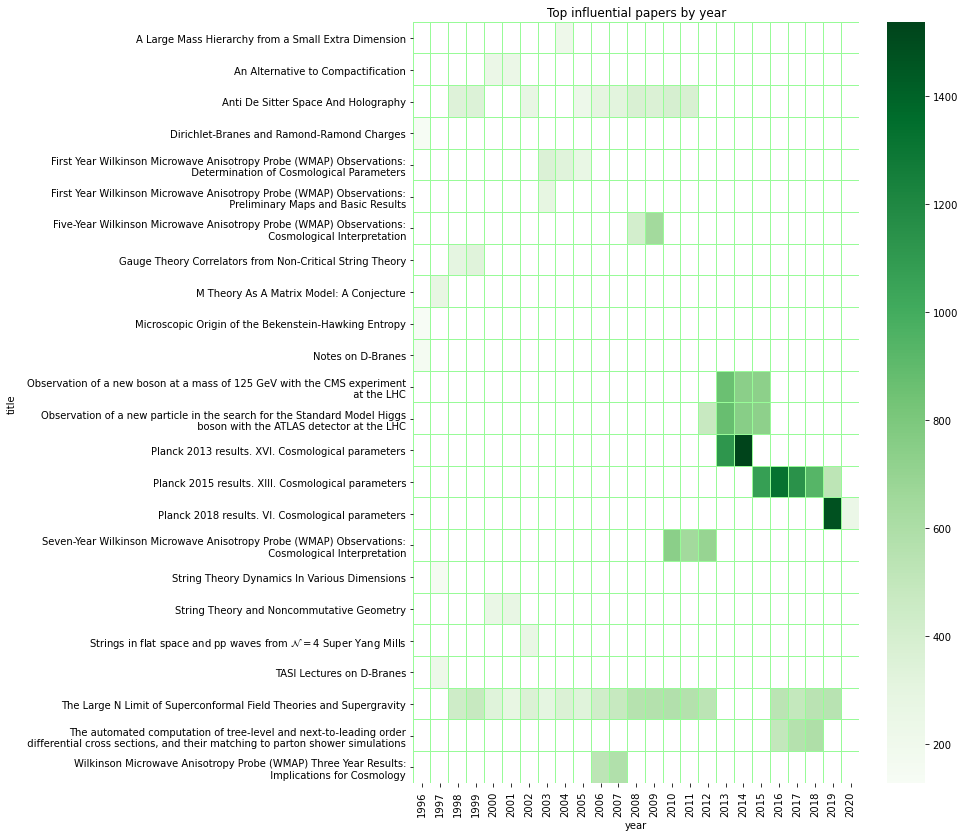

In [12]:
cits = top_k_influential (group_name, top_k=3)
show_influential_heatmap (group_name, cits=cits, figsize=(10,14))


In [13]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,The Large N Limit of Superconformal Field Theories and Supergravity,Juan M. Maldacena,"We show that the large $N$ limit of certain conformal field theories in various dimensions include in their Hilbert space a sector describing supergravity on the product of Anti-deSitter spacetimes, spheres and other compact manifolds. This is shown by taking some branes in the full M/string theory and then taking a low energy limit where the field theory on the brane decouples from the bulk. We observe that, in this limit, we can still trust the near horizon geometry for large $N$. The enhanced supersymmetries of the near horizon geometry correspond to the extra supersymmetry generators present in the superconformal group (as opposed to just the super-Poincare group). The 't Hooft limit of 4-d ${\cal N} =4$ super-Yang-Mills at the conformal point is shown to contain strings: they are IIB strings. We conjecture that compactifications of M/string theory on various Anti-deSitter spacetimes are dual to various conformal field theories. This leads to a new proposal for a definition of M-theory which could be extended to include five non-compact dimensions.",https://arxiv.org/pdf/hep-th/9711200,8770
1,Planck 2015 results. XIII. Cosmological parameters,"Planck Collaboration: P. A. R. Ade, N. Aghanim,...","We present results based on full-mission Planck observations of temperature and polarization anisotropies of the CMB. These data are consistent with the six-parameter inflationary LCDM cosmology. From the Planck temperature and lensing data, for this cosmology we find a Hubble constant, H0= (67.8 +/- 0.9) km/s/Mpc, a matter density parameter Omega_m = 0.308 +/- 0.012 and a scalar spectral index with n_s = 0.968 +/- 0.006. (We quote 68% errors on measured parameters and 95% limits on other parameters.) Combined with Planck temperature and lensing data, Planck LFI polarization measurements lead to a reionization optical depth of tau = 0.066 +/- 0.016. Combining Planck with other astrophysical data we find N_ eff = 3.15 +/- 0.23 for the effective number of relativistic degrees of freedom and the sum of neutrino masses is constrained to < 0.23 eV. Spatial curvature is found to be |Omega_K| < 0.005. For LCDM we find a limit on the tensor-to-scalar ratio of r <0.11 consistent with the B-mode constraints from an analysis of BICEP2, Keck Array, and Planck (BKP) data. Adding the BKP data leads to a tighter constraint of r < 0.09. We find no evidence for isocurvature perturbations or cosmic defects. The equation of state of dark energy is constrained to w = -1.006 +/- 0.045. Standard big bang nucleosynthesis predictions for the Planck LCDM cosmology are in excellent agreement with observations. We investigate annihilating dark matter and deviations from standard recombination, finding no evidence for new physics. The Planck results for base LCDM are in agreement with BAO data and with the JLA SNe sample. However the amplitude of the fluctuations is found to be higher than inferred from rich cluster counts and weak gravitational lensing. Apart from these tensions, the base LCDM cosmology provides an excellent description of the Planck CMB observations and many other astrophysical data sets.",https://arxiv.org/pdf/1502.01589,5004
2,Anti De Sitter Space And Holography,Edward Witten,"Recently, it has been proposed by Maldacena that large $N$ limits of certain conformal field theories in $d$ dimensions can be described in terms of supergravity (and string theory) on the product of $d+1$-dimensional $AdS$ space with a compact manifold. Here we elaborate on this idea and propose a precise correspondence between conformal field theory observables and those of supergravity: correlation functions in conformal field theory are given by the dependence of the supergravity action on the asymptotic behavior at infinity. In particular, dimensions of operators in conformal field theory are given by masses of particles in supergravit

## Mathematics

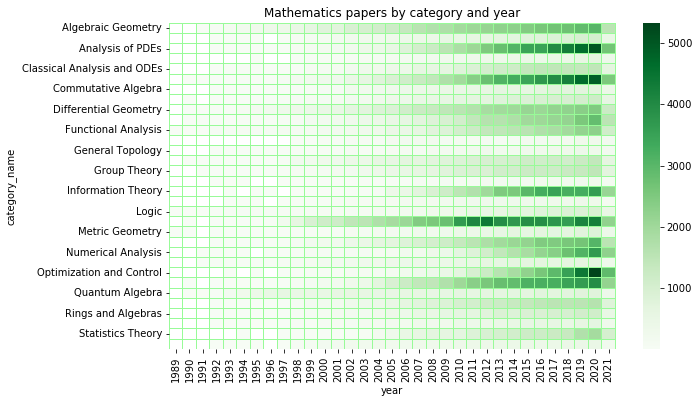

In [22]:
group_name="Mathematics"
show_count_by_category_and_year (group_name,figsize=(10,6))

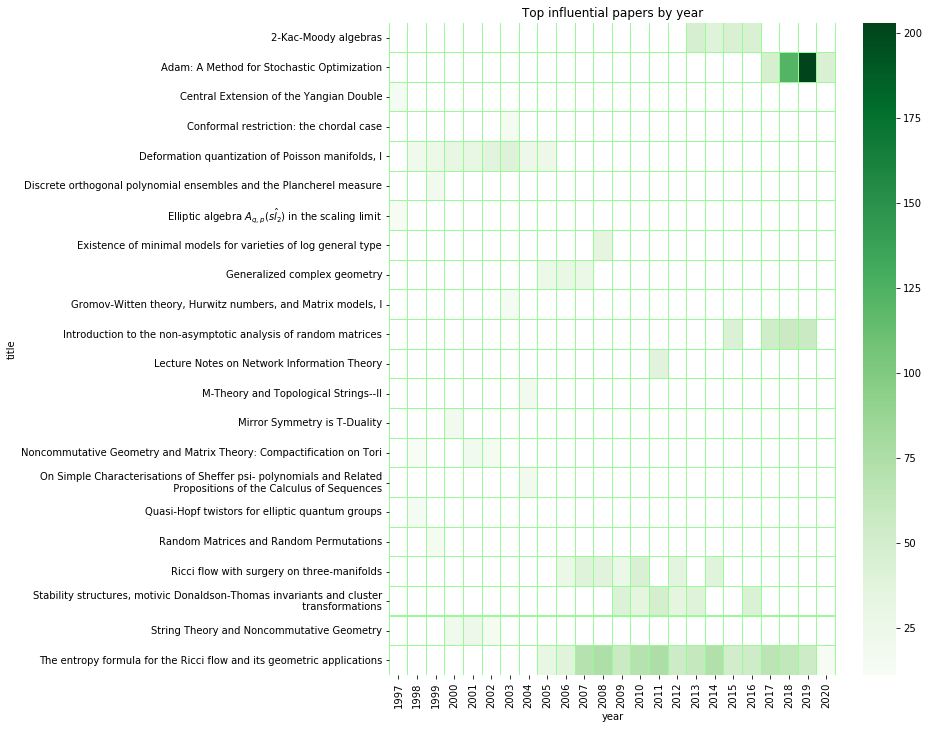

In [23]:
cits = top_k_influential (group_name, top_k=3, threshold=10)
show_influential_heatmap (group_name, cits=cits, figsize=(10,12))

In [24]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,The entropy formula for the Ricci flow and its geometric applications,Grisha Perelman,"We present a monotonic expression for the Ricci flow, valid in all dimensions and without curvature assumptions. It is interpreted as an entropy for a certain canonical ensemble. Several geometric applications are given. In particular, (1) Ricci flow, considered on the space of riemannian metrics modulo diffeomorphism and scaling, has no nontrivial periodic orbits (that is, other than fixed points); (2) In a region, where singularity is forming in finite time, the injectivity radius is controlled by the curvature; (3) Ricci flow can not quickly turn an almost euclidean region into a very curved one, no matter what happens far away. We also verify several assertions related to Richard Hamilton's program for the proof of Thurston geometrization conjecture for closed three-manifolds, and give a sketch of an eclectic proof of this conjecture, making use of earlier results on collapsing with local lower curvature bound.",https://arxiv.org/pdf/math/0211159,904
1,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,418
2,Ricci flow with surgery on three-manifolds,Grisha Perelman,"This is a technical paper, which is a continuation of math.DG/0211159. Here we construct Ricci flow with surgeries and verify most of the assertions, made in section 13 of that e-print; the exceptions are (1) the statement that manifolds that can collapse with local lower bound on sectional curvature are graph manifolds - this is deferred to a separate paper, since the proof has nothing to do with the Ricci flow, and (2) the claim on the lower bound for the volume of maximal horns and the smoothness of solutions from some time on, which turned out to be unjustified and, on the other hand, irrelevant for the other conclusions.",https://arxiv.org/pdf/math/0303109,251
3,"Stability structures, motivic Donaldson-Thomas invariants and cluster transformations","Maxim Kontsevich, Yan Soibelman","We define new invariants of 3d Calabi-Yau categories endowed with a stability structure. Intuitively, they count the number of semistable objects with fixed class in the K-theory of the category (""number of BPS states with given charge"" in physics language). Formally, our motivic DT-invariants are elements of quantum tori over a version of the Grothendieck ring of varieties over the ground field. Via the quasi-classical limit ""as the motive of affine line approaches to 1"" we obtain numerical DT-invariants which are closely related to those introduced by Behrend. We study some properties of both motivic and numerical DT-invariants including the wall-crossing formulas and integrality. We discuss the relationship with the mathematical works (in the non-triangulated case) of Joyce, Bridgeland and Toledano-

## Computer Science

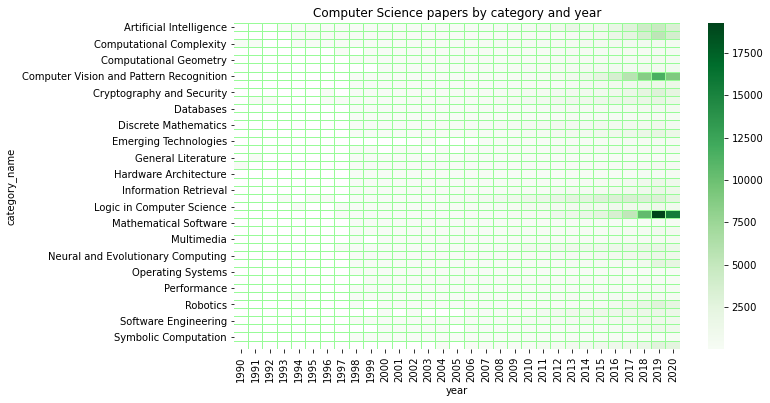

In [17]:
group_name="Computer Science"
show_count_by_category_and_year (group_name,figsize=(10,6))

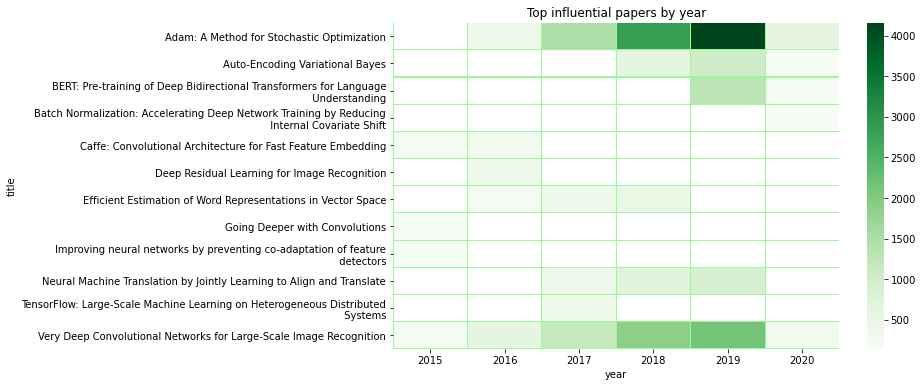

In [18]:
cits = top_k_influential (group_name, top_k=5)
show_influential_heatmap (group_name, cits=cits, figsize=(10,6))

In [19]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,9567
1,Very Deep Convolutional Networks for Large-Scale Image Recognition,"Karen Simonyan, Andrew Zisserman","In this work we investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. Our main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers. These findings were the basis of our ImageNet Challenge 2014 submission, where our team secured the first and the second places in the localisation and classification tracks respectively. We also show that our representations generalise well to other datasets, where they achieve state-of-the-art results. We have made our two best-performing ConvNet models publicly available to facilitate further research on the use of deep visual representations in computer vision.",https://arxiv.org/pdf/1409.1556,6362
2,Neural Machine Translation by Jointly Learning to Align and Translate,Dzmitry Bahdanau and Kyunghyun Cho and Yoshua B...,"Neural machine translation is a recently proposed approach to machine translation. Unlike the traditional statistical machine translation, the neural machine translation aims at building a single neural network that can be jointly tuned to maximize the translation performance. The models proposed recently for neural machine translation often belong to a family of encoder-decoders and consists of an encoder that encodes a source sentence into a fixed-length vector from which a decoder generates a translation. In this paper, we conjecture that the use of a fixed-length vector is a bottleneck in improving the performance of this basic encoder-decoder architecture, and propose to extend this by allowing a model to automatically (soft-)search for parts of a source sentence that are relevant to predicting a target word, without having to form these parts as a hard segment explicitly. With this new approach, we achieve a translation performance comparable to the existing state-of-the-art phrase-based system on the task of English-to-French translation. Furthermore, qualitative analysis reveals that the (soft-)alignments found by the model agree well with our intuition.",https://arxiv.org/pdf/1409.0473,2046
3,Auto-Encoding Variational Bayes,"Diederik P Kingma, Max Welling","How can we perform efficient inference and learning in directed probabilistic models, in the presence of continuous latent variables with intractable posterior distributions, and large datasets? We introduce a stochastic variational inference and learning algorithm that scales to large datasets

## Statistics

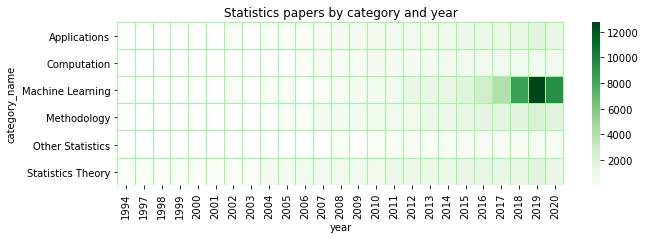

In [20]:
group_name="Statistics"
show_count_by_category_and_year (group_name,figsize=(10,3))

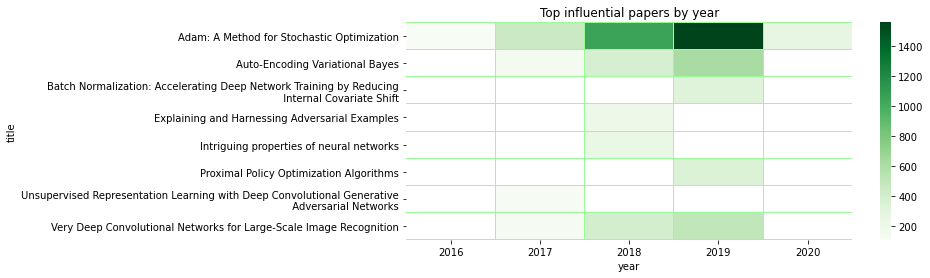

In [21]:
cits = top_k_influential (group_name, top_k=5)
show_influential_heatmap (group_name, cits=cits, figsize=(10,4))

In [22]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,3447
1,Auto-Encoding Variational Bayes,"Diederik P Kingma, Max Welling","How can we perform efficient inference and learning in directed probabilistic models, in the presence of continuous latent variables with intractable posterior distributions, and large datasets? We introduce a stochastic variational inference and learning algorithm that scales to large datasets and, under some mild differentiability conditions, even works in the intractable case. Our contributions is two-fold. First, we show that a reparameterization of the variational lower bound yields a lower bound estimator that can be straightforwardly optimized using standard stochastic gradient methods. Second, we show that for i.i.d. datasets with continuous latent variables per datapoint, posterior inference can be made especially efficient by fitting an approximate inference model (also called a recognition model) to the intractable posterior using the proposed lower bound estimator. Theoretical advantages are reflected in experimental results.",https://arxiv.org/pdf/1312.6114,1149
2,Very Deep Convolutional Networks for Large-Scale Image Recognition,"Karen Simonyan, Andrew Zisserman","In this work we investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. Our main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers. These findings were the basis of our ImageNet Challenge 2014 submission, where our team secured the first and the second places in the localisation and classification tracks respectively. We also show that our representations generalise well to other datasets, where they achieve state-of-the-art results. We have made our two best-performing ConvNet models publicly available to facilitate further research on the use of deep visual representations in computer vision.",https://arxiv.org/pdf/1409.1556,1049
3,Proximal Policy Optimization Algorithms,"John Schulman, Filip Wolski, Prafulla Dhariwal,...","We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a ""surrogate"" objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO

## Quantitative Biology

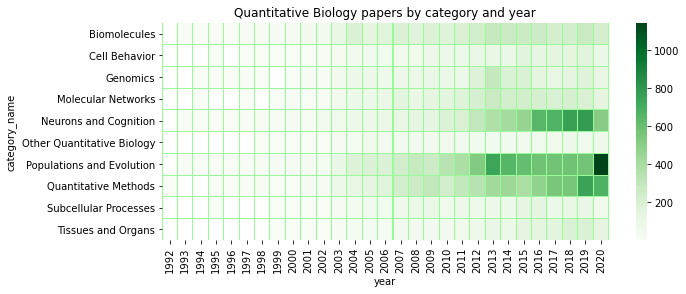

In [23]:
group_name="Quantitative Biology"
show_count_by_category_and_year (group_name,figsize=(10,4))

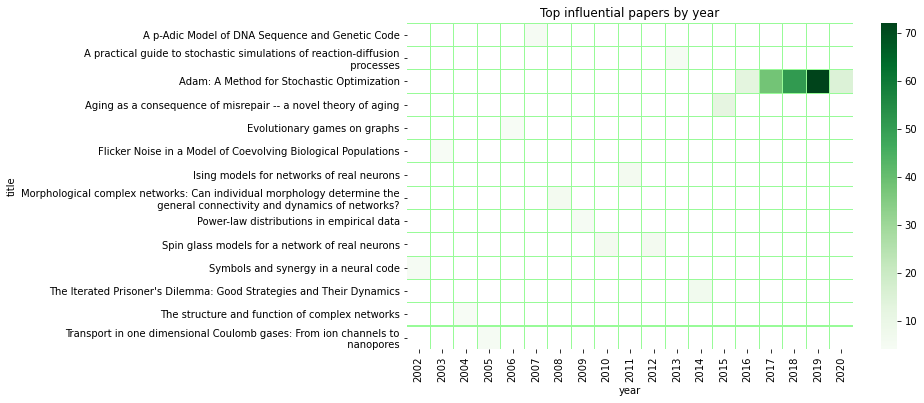

In [24]:
cits = top_k_influential (group_name, top_k=1, threshold=3)
show_influential_heatmap (group_name, cits=cits, figsize=(10,6))

In [25]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,189
1,Aging as a consequence of misrepair -- a novel theory of aging,"Jicun Wang (CUH), Thomas Michelitsch (IJLRA), A...","It is now increasingly realized that the underlying mechanism which governs aging (ageing) is a complex interplay of genetic regulation and damage-accumulation. ""Aging as a result of accumulation of 'faults' on cellular and molecular levels"", has been proposed in the damage (fault)-accumulation theory. However, this theory fails to explain some aging phenotypes such as fibrosis and premature aging, since terms such as 'damage' and 'fault' are not specified. Therefore we introduce some crucial modifications of this theory and arrive at a novel theory: aging of the body is the result of accumulation of Misrepair of tissue. It emphasizes: a) it is Misrepair, not the original damage, that accumulates and leads to aging; and b) aging can occur at different levels, however aging of the body takes place necessarily on the tissue level, but not requiring the aging of cells/molecules. The Misrepair-accumulation theory introduced in the present paper unifies the understanding of the roles of environmental damage, repair, gene regulation, and multicellular structure in the aging process. This theory gives explanations for the aging phenotypes, premature aging, the difference of longevity in different species, and it is consistent with the physical view on complex systems.",https://arxiv.org/pdf/0904.0575,12
2,Spin glass models for a network of real neurons,"Gasper Tkacik, Elad Schneidman, Michael J. Berr...","Ising models with pairwise interactions are the least structured, or maximum-entropy, probability distributions that exactly reproduce measured pairwise correlations between spins. Here we use this equivalence to construct Ising models that describe the correlated spiking activity of populations of 40 neurons in the salamander retina responding to natural movies. We show that pairwise interactions between neurons account for observed higher-order correlations, and that for groups of 10 or more neurons pairwise interactions can no longer be regarded as small perturbations in an independent system. We then construct network ensembles that generalize the network instances observed in the experiment, and study their thermodynamic behavior and coding capacity. Based on this construction, we can also create synthetic networks of 120 neurons, and find that with increasing size the networks operate closer to a critical point and start exhibiting collective behaviors reminiscent of spin glasses. We examine closely two such behaviors that could be relevant for neural code: tuning of the network to the critical point to maximize the ability to encode diverse stimuli, and using the meta

## Electrical Engineering and Systems Science

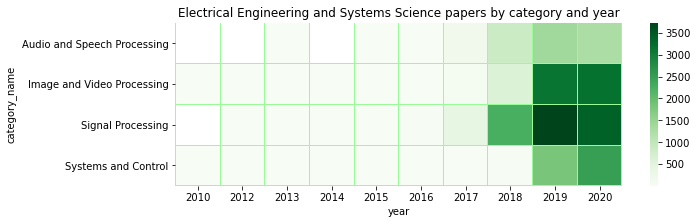

In [26]:
group_name="Electrical Engineering and Systems Science"

show_count_by_category_and_year (group_name,figsize=(10,3))

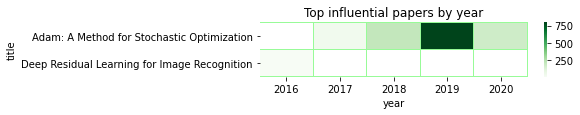

In [27]:
cits = top_k_influential (group_name, top_k=1, threshold=1)
show_influential_heatmap (group_name, cits=cits, figsize=(6,1))

In [28]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,1223
1,Deep Residual Learning for Image Recognition,"Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun","Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers. The depth of representations is of central importance for many visual recognition tasks. Solely due to our extremely deep representations, we obtain a 28% relative improvement on the COCO object detection dataset. Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions, where we also won the 1st places on the tasks of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation.",https://arxiv.org/pdf/1512.03385,3


## Quantitative Finance

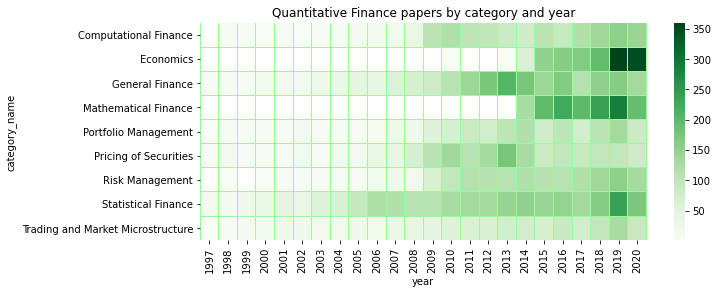

In [29]:
group_name="Quantitative Finance"

show_count_by_category_and_year (group_name,figsize=(10,4))

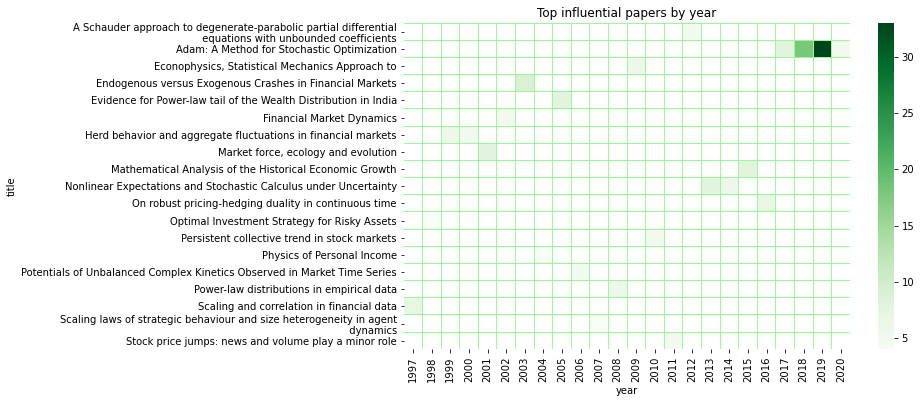

In [30]:
cits = top_k_influential (group_name, top_k=1, threshold=3)
show_influential_heatmap (group_name, cits=cits, figsize=(10,6))

In [31]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Adam: A Method for Stochastic Optimization,Diederik P. Kingma and Jimmy Ba,"We introduce Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning. Some connections to related algorithms, on which Adam was inspired, are discussed. We also analyze the theoretical convergence properties of the algorithm and provide a regret bound on the convergence rate that is comparable to the best known results under the online convex optimization framework. Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods. Finally, we discuss AdaMax, a variant of Adam based on the infinity norm.",https://arxiv.org/pdf/1412.6980,64
1,Nonlinear Expectations and Stochastic Calculus under Uncertainty,Shige Peng,"In this book, we introduce a new approach of sublinear expectation to deal with the problem of probability and distribution model uncertainty. We a new type of (robust) normal distributions and the related central limit theorem under sublinear expectation. We also present a new type of Brownian motion under sublinear expectations and the related stochastic calculus of Ito's type. The results provide robust tools for the problem of probability model uncertainty arising from financial risk management, statistics and stochastic controls.",https://arxiv.org/pdf/1002.4546,14
2,Herd behavior and aggregate fluctuations in financial markets,Rama Cont and Jean-Philippe Bouchaud (CEA Sacla...,"We present a simple model of a stock market where a random communication structure between agents gives rise to a heavy tails in the distribution of stock price variations in the form of an exponentially truncated power-law, similar to distributions observed in recent empirical studies of high frequency market data. Our model provides a link between two well-known market phenomena: the heavy tails observed in the distribution of stock market returns on one hand and 'herding' behavior in financial markets on the other hand. In particular, our study suggests a relation between the excess kurtosis observed in asset returns, the market order flow and the tendency of market participants to imitate each other.",https://arxiv.org/pdf/cond-mat/9712318,11
3,Endogenous versus Exogenous Crashes in Financial Markets,"A. Johansen (Riso National Lab., Denmark) and D...","We perform an extended analysis of the distribution of drawdowns in the two leading exchange markets (US dollar against the Deutsmark and against the Yen), in the major world stock markets, in the U.S. and Japanese bond market and in the gold market, by introducing the concept of ``coarse-grained drawdowns,'' which allows for a certain degree of fuzziness in the definition of cumulative losses and improves on the statistics of our previous results on the existence of ``outliers'' or ``kings.'' Then, for each identified outlier, we check whether log-periodic power law signatures (LPPS) are present and take the existence of LPPS as the qualifying signature for an endogenous crash: this is because a drawdown outlier is seen as the end of a speculative unsustainable accelerating bubble generated endogenously. In the absence of LPPS, we are able to identify what seems to have been the relevant historical event, i.e., a new piece of information of such magnitude and impact that it is seems reasonable to attribute the crash to it, in agreement with the standard view of the efficient ma

## Economics

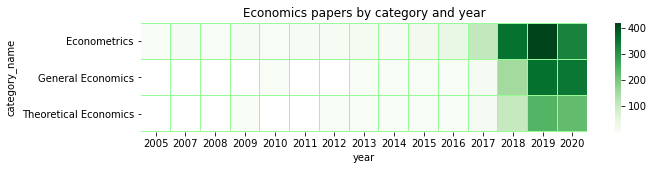

In [32]:
group_name="Economics"

show_count_by_category_and_year (group_name,figsize=(10,2))

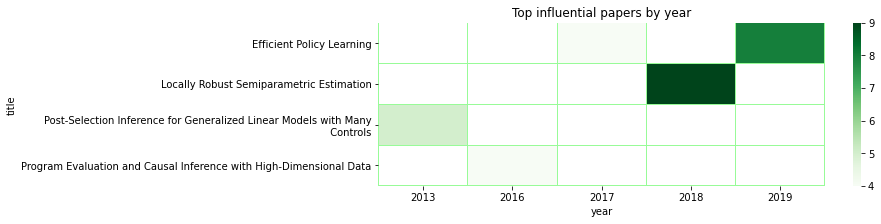

In [33]:
cits = top_k_influential (group_name, top_k=1, threshold=3)
show_influential_heatmap (group_name, cits=cits, figsize=(10,3))

In [34]:
show_influential_table (cits)

,title,authors,abstract,url,references
0,Efficient Policy Learning,Susan Athey and Stefan Wager,"In many areas, practitioners seek to use observational data to learn a treatment assignment policy that satisfies application-specific constraints, such as budget, fairness, simplicity, or other functional form constraints. For example, policies may be restricted to take the form of decision trees based on a limited set of easily observable individual characteristics. We propose a new approach to this problem motivated by the theory of semiparametrically efficient estimation. Our method can be used to optimize either binary treatments or infinitesimal nudges to continuous treatments, and can leverage observational data where causal effects are identified using a variety of strategies, including selection on observables and instrumental variables. Given a doubly robust estimator of the causal effect of assigning everyone to treatment, we develop an algorithm for choosing whom to treat, and establish strong guarantees for the asymptotic utilitarian regret of the resulting policy.",https://arxiv.org/pdf/1702.02896,12
1,Locally Robust Semiparametric Estimation,"Victor Chernozhukov, Juan Carlos Escanciano, Hi...","Many economic and causal parameters depend on nonparametric or high dimensional first steps. We give a general construction of locally robust/orthogonal moment functions for GMM, where moment conditions have zero derivative with respect to first steps. We show that orthogonal moment functions can be constructed by adding to identifying moments the nonparametric influence function for the effect of the first step on identifying moments. Orthogonal moments reduce model selection and regularization bias, as is very important in many applications, especially for machine learning first steps. We give debiased machine learning estimators of functionals of high dimensional conditional quantiles and of dynamic discrete choice parameters with high dimensional state variables. We show that adding to identifying moments the nonparametric influence function provides a general construction of orthogonal moments, including regularity conditions, and show that the nonparametric influence function is robust to additional unknown functions on which it depends. We give a general approach to estimating the unknown functions in the nonparametric influence function and use it to automatically debias estimators of functionals of high dimensional conditional location learners. We give a variety of new doubly robust moment equations and characterize double robustness. We give general and simple regularity conditions and apply these for asymptotic inference on functionals of high dimensional regression quantiles and dynamic discrete choice parameters with high dimensional state variables.",https://arxiv.org/pdf/1608.00033,9
2,Post-Selection Inference for Generalized Linear Models with Many Controls,Alexandre Belloni and Victor Chernozhukov and Y...,"This paper considers generalized linear models in the presence of many controls. We lay out a general methodology to estimate an effect of interest based on the construction of an instrument that immunize against model selection mistakes and apply it to the case of logistic binary choice model. More specifically we propose new methods for estimating and constructing confidence regions for a regression parameter of primary interest $\alpha_0$, a parameter in front of the regressor of interest, such as the treatment variable or a policy variable. These methods allow to estimate $\alpha_0$ at the root-$n$ rate when the total number $p$ of other regressors, called controls, potentially exceed the sample size $n$ using sparsity assumptions. The sparsity assumption means that there is a subset of $s<n$ controls which suffices to accurately approximate the nuisance part of the regression function. Importantly, the estimators and these resulting confidence regions are valid uniformly over $s$-sparse models satisfy

## 'Adam: A Method for Stochastic Optimization'

Unsurprisingly, this 2015 paper by Diederik P. Kingma and Jimmy Ba is the most interdisciplinary referenced paper, for the effectiveness of its use with deep neural networks.


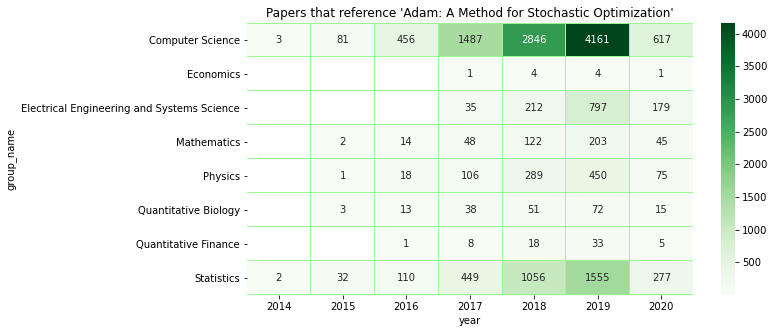

In [35]:
df = df_citations.query("id_reference == '1412.6980'")\
.merge(df_categories,on="id")\
.merge(df_taxonomy,on="category_id").drop_duplicates(["id","group_name"])\
.merge(df_versions.query("version =='v1'")[["id","year"]], on ="id")


hmap =df.groupby(["group_name","year"]).agg({"id":"count"}).reset_index().pivot(index=["group_name"], columns="year",values="id") 

plt.figure(figsize=(10,5))
plt.title("Papers that reference 'Adam: A Method for Stochastic Optimization'")
sns.heatmap(hmap,cmap="Greens", linewidths=0.01, linecolor='palegreen', annot=True, fmt=".0f")
plt.show()



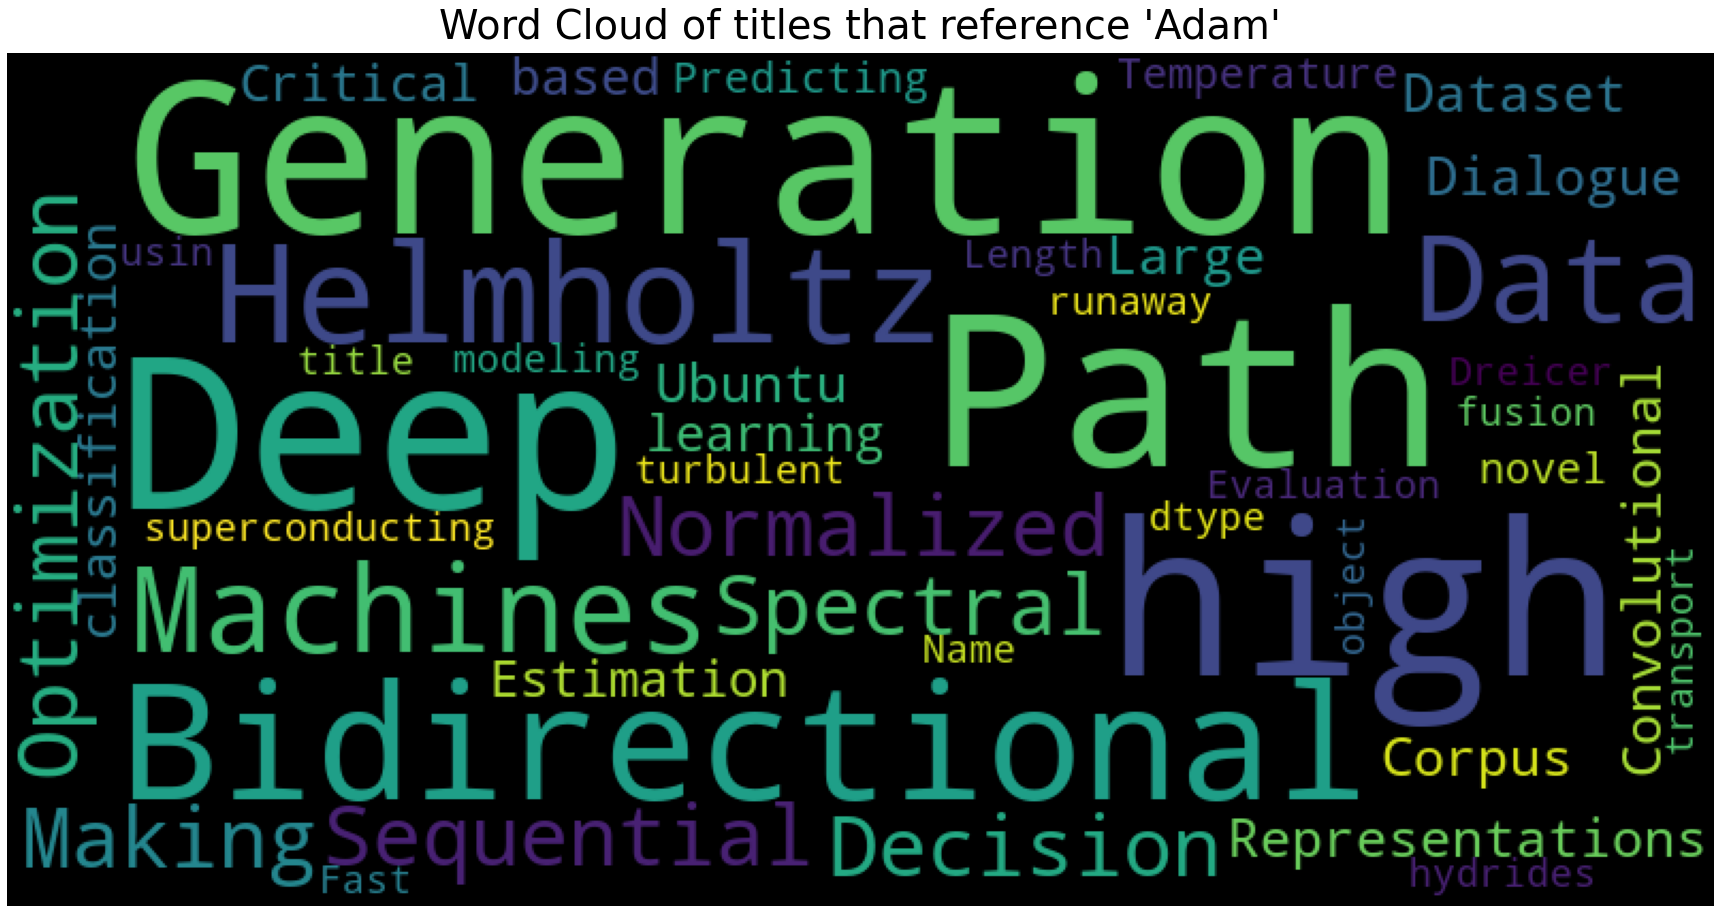

In [36]:

_df = df.drop_duplicates(["id"]).merge(df_papers,on="id")
_df = _df.sample(frac=1, axis=1).reset_index(drop=True)

_df ["url"] = _df["id"].map(lambda x:  f'https://arxiv.org/pdf/{x}' ) 
_df ["authors"] = _df["authors"].map(lambda x: x if len(str(x)) < 50 else str(x)[:47] + "..." )

_df =_df [["group_name","title","authors","abstract","url","year"]]
    
    
plot_wordcloud(_df["title"], title="Word Cloud of titles that reference 'Adam'")

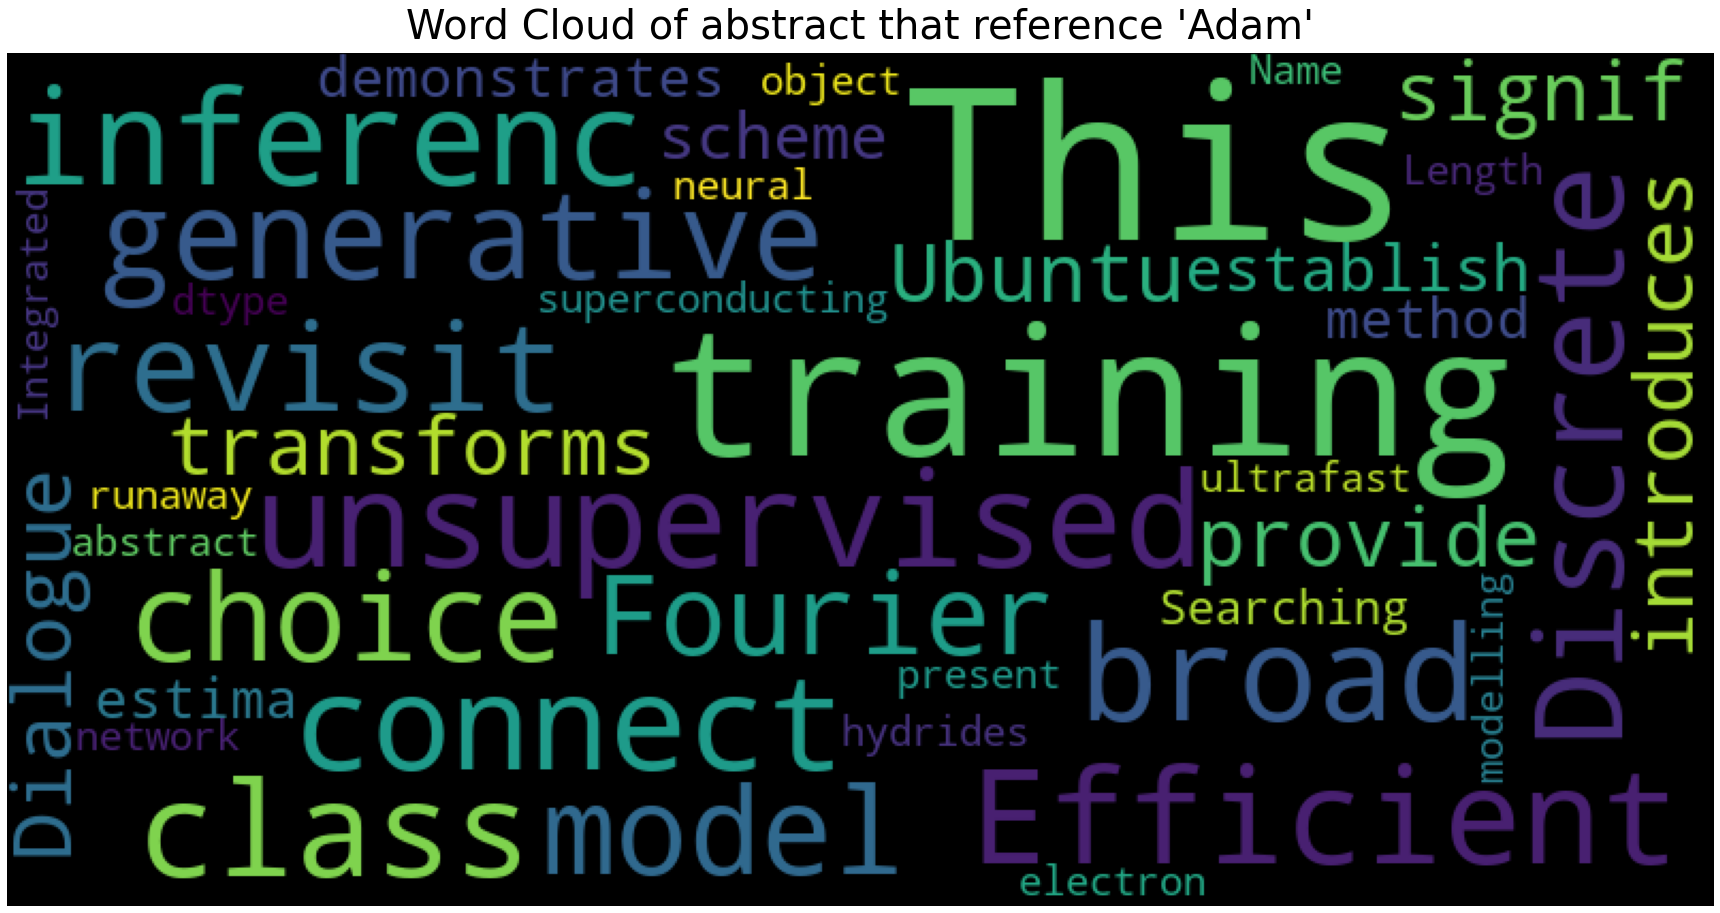

In [37]:
plot_wordcloud(_df["abstract"], title="Word Cloud of abstract that reference 'Adam'")

Here some random papers that reference this paper

In [38]:
_sample_df = _df.groupby(["group_name"]).head(3)
_sample_df.style.format({'url': make_clickable})

,group_name,title,authors,abstract,url,year
0,Computer Science,Bidirectional Helmholtz Machines,Jorg Bornschein and Samira Shabanian and Asja F...,"Efficient unsupervised training and inference in deep generative models remains a challenging problem. One basic approach, called Helmholtz machine, involves training a top-down directed generative model together with a bottom-up auxiliary model used for approximate inference. Recent results indicate that better generative models can be obtained with better approximate inference procedures. Instead of improving the inference procedure, we here propose a new model which guarantees that the top-down and bottom-up distributions can efficiently invert each other. We achieve this by interpreting both the top-down and the bottom-up directed models as approximate inference distributions and by defining the model distribution to be the geometric mean of these two. We present a lower-bound for the likelihood of this model and we show that optimizing this bound regularizes the model so that the Bhattacharyya distance between the bottom-up and top-down approximate distributions is minimized. This approach results in state of the art generative models which prefer significantly deeper architectures while it allows for orders of magnitude more efficient approximate inference.",https://arxiv.org/pdf/1506.03877,2015
1,Computer Science,Data Generation as Sequential Decision Making,Philip Bachman and Doina Precup,"We connect a broad class of generative models through their shared reliance on sequential decision making. Motivated by this view, we develop extensions to an existing model, and then explore the idea further in the context of data imputation -- perhaps the simplest setting in which to investigate the relation between unconditional and conditional generative modelling. We formulate data imputation as an MDP and develop models capable of representing effective policies for it. We construct the models using neural networks and train them using a form of guided policy search. Our models generate predictions through an iterative process of feedback and refinement. We show that this approach can learn effective policies for imputation problems of varying difficulty and across multiple datasets.",https://arxiv.org/pdf/1506.03504,2015
2,Computer Science,Path-SGD: Path-Normalized Optimization in Deep Neural Networks,"Behnam Neyshabur, Ruslan Salakhutdinov, Nathan ...","We revisit the choice of SGD for training deep neural networks by reconsidering the appropriate geometry in which to optimize the weights. We argue for a geometry invariant to rescaling of weights that does not affect the output of the network, and suggest Path-SGD, which is an approximate steepest descent method with respect to a path-wise regularizer related to max-norm regularization. Path-SGD is easy and efficient to implement and leads to empirical gains over SGD and AdaGrad.",https://arxiv.org/pdf/1506.02617,2015
5138,Statistics,Automatic Variational Inference in Stan,"Alp Kucukelbir, Rajesh Ranganath, Andrew Gelman...","Variational inference is a scalable technique for approximate Bayesian inference. Deriving variational inference algorithms requires tedious model-specific calculations; this makes it difficult to automate. We propose an automatic variational inference algorithm, automatic differentiation variational inference (ADVI). The user only provides a Bayesian model and a dataset; nothing else. We make no conjugacy assumptions and support a broad class of models. The algorithm automatically determines an appropriate variational family and optimizes the variational objective. We implement ADVI in Stan (code available now), a probabilistic programming framework. We compare ADVI to MCMC sampling across hierarchical generalized linear models, nonconjugate matrix factorization, and a mixture model. We train the mixture model on a quarter million images. With ADVI we can use variational inference on any model we write in St

**Now use graphing utilities**

In [27]:
import networkx as nx

g = nx.DiGraph()

In [34]:
def merge_results_with_papers(results):
    df_results = pd.DataFrame(results, columns=["id", "citations"])
    return df_results.merge(df_papers,on="id")

In [30]:
group_name ="Mathematics"
ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name ==@group_name")["id"].values
cits = df_citations.query( 'id.isin(@ids)', engine="python" ).merge( df_versions.query("version == 'v1'")[["id","year"]], on ="id")

In [31]:
import pandas as pd
G = nx.from_pandas_edgelist(cits,  source='id_reference', target='id', create_using = nx.DiGraph)

In [37]:
cits.head(10)

,id,id_reference,year
0,hep-lat/0004015,hep-lat/9911022,2000
1,hep-lat/0004015,hep-lat/9910030,2000
2,hep-lat/0004015,hep-lat/9812003,2000
3,hep-lat/0004015,hep-th/9912003,2000
4,hep-lat/0004015,hep-lat/9602030,2000
5,hep-lat/0004015,hep-lat/0004015,2000
6,hep-lat/0004015,hep-lat/9912013,2000
7,hep-lat/0004015,hep-lat/9911000,2000
8,hep-lat/0004015,hep-lat/0002032,2000
9,hep-lat/0004015,hep-lat/0002009,2000


In [35]:
x = list(G.degree())
x.sort(key=lambda y : y[1], reverse=True )

citations_by_deg = merge_results_with_papers(x)
citations_by_deg.head(20)

,id,citations,title,abstract,authors,journal-ref,license
0,1004.3169,1267,Factorizations of Cunningham numbers with base...,This Report updates the tables of factorizat...,"Richard P. Brent, Peter L. Montgomery and Herm...",None,http://arxiv.org/licenses/nonexclusive-distrib...
1,math/0211159,935,The entropy formula for the Ricci flow and its...,We present a monotonic expression for the Ri...,Grisha Perelman,None,None
2,1712.03107,538,Dynamical systems applied to cosmology: dark e...,The Nobel Prize winning confirmation in 1998...,"Sebastian Bahamonde, Christian G. Boehmer, San...",Physics Reports Vol. 775-777 (2018) 1-122,http://arxiv.org/licenses/nonexclusive-distrib...
3,0801.2826,522,"Non-Commutative Geometry, Categories and Quant...",After an introduction to some basic issues i...,"Paolo Bertozzini (1), Roberto Conti (2), Wicha...","East-West Journal of Mathematics ""Contribution...",http://arxiv.org/licenses/nonexclusive-distrib...
4,q-alg/9709040,517,"Deformation quantization of Poisson manifolds, I",I prove that every finite-dimensional Poisso...,Maxim Kontsevich,"Lett.Math.Phys.66:157-216,2003",None
5,0811.2435,517,"Stability structures, motivic Donaldson-Thomas...",We define new invariants of 3d Calabi-Yau ca...,"Maxim Kontsevich, Yan Soibelman",None,http://arxiv.org/licenses/nonexclusive-distrib...
6,math/0303109,506,Ricci flow with surgery on three-manifolds,"This is a technical paper, which is a contin...",Grisha Perelman,None,None
7,hep-th/0109162,443,Quantum Field Theory on Noncommutative Spaces,A pedagogical and self-contained introductio...,Richard J. Szabo,"Phys.Rept.378:207-299,2003",None
8,hep-th/9711200,438,The Large N Limit of Superconformal Field Theo...,We show that the large $N$ limit of certain ...,Juan M. Maldacena,"Adv.Theor.Math.Phys.2:231-252,1998",None
9,1412.6980,434,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,http://arxiv.org/licenses/nonexclusive-distrib...


In [40]:
df_versions.head(5)

,id,version,created,year,month
0,0704.0001,v1,2007-04-02 19:18:42+00:00,2007,4
1,0704.0001,v2,2007-07-24 20:10:27+00:00,2007,7
2,0704.0002,v1,2007-03-31 02:26:18+00:00,2007,3
3,0704.0002,v2,2008-12-13 17:26:00+00:00,2008,12
4,0704.0003,v1,2007-04-01 20:46:54+00:00,2007,4


In [39]:
df_papers.head(10)

,id,title,abstract,authors,journal-ref,license
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","Phys.Rev.D76:013009,2007",None
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,None,http://arxiv.org/licenses/nonexclusive-distrib...
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,Hongjun Pan,None,None
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,David Callan,None,None
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"Illinois J. Math. 52 (2008) no.2, 681-689",None
5,0704.0006,Bosonic characters of atomic Cooper pairs acro...,We study the two-particle wave function of p...,Y. H. Pong and C. K. Law,None,None
6,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation...,"Alejandro Corichi, Tatjana Vukasinac and Jose ...","Phys.Rev.D76:044016,2007",None
7,0704.0008,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,Damian C. Swift,"Journal of Applied Physics, vol 104, 073536 (2...",http://arxiv.org/licenses/nonexclusive-distrib...
8,0704.0009,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...","Astrophys.J.663:1149-1173,2007",None
9,0704.0010,"Partial cubes: structures, characterizations, ...",Partial cubes are isometric subgraphs of hyp...,Sergei Ovchinnikov,None,None


In [43]:
df_versions = df_versions.sort_values(['year', 'month'])

In [46]:
df_versions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000645 entries, 2958760 to 2831375
Data columns (total 5 columns):
 #   Column   Dtype              
---  ------   -----              
 0   id       object             
 1   version  object             
 2   created  datetime64[ns, UTC]
 3   year     int64              
 4   month    int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 137.4+ MB


In [64]:
df_versions.head(5)

,id,version,created,year,month
2958760,physics/9403001,v1,1986-04-25 15:39:49+00:00,1986,4
2791833,hep-th/9108028,v1,1988-11-11 15:39:49+00:00,1988,11
2901461,math/9201239,v1,1989-04-15 00:00:00+00:00,1989,4
2901420,math/9201203,v1,1989-10-26 14:59:00+00:00,1989,10
2901421,math/9201204,v1,1989-10-26 14:59:00+00:00,1989,10


In [81]:
group_name ="Physics"
ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name ==@group_name")["id"].values

In [82]:
df_versions_per = df_versions.query( 'id.isin(@ids)', engine="python" ) \
                             .query("version == 'v1'").query("year > 2005").groupby(['year', 'month']).count().reset_index()

In [83]:
df_versions_per

,year,month,id,version,created
0,2006,1,2291,2291,2291
1,2006,2,2190,2190,2190
2,2006,3,2576,2576,2576
3,2006,4,2259,2259,2259
4,2006,5,2556,2556,2556
...,...,...,...,...,...
182,2021,3,6707,6707,6707
183,2021,4,5894,5894,5894
184,2021,5,6077,6077,6077
185,2021,6,6049,6049,6049


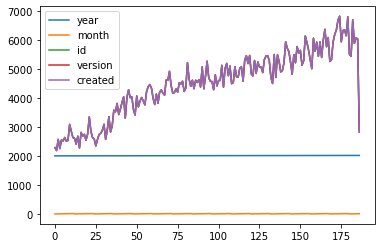

In [84]:
df_versions_per.plot()

In [85]:
df_versions_per.describe()

,year,month,id,version,created
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,2013.299465,6.406417,4487.005348,4487.005348,4487.005348
std,4.514749,3.450972,1143.431298,1143.431298,1143.431298
min,2006.000000,1.000000,2190.000000,2190.000000,2190.000000
25%,2009.000000,3.000000,3799.000000,3799.000000,3799.000000
50%,2013.000000,6.000000,4609.000000,4609.000000,4609.000000
75%,2017.000000,9.000000,5302.000000,5302.000000,5302.000000
max,2021.000000,12.000000,6829.000000,6829.000000,6829.000000


In [49]:
df_versions[(df_versions['year'] == 2021) & (df_versions['month'] == 3)].shape

(28206, 5)

In [38]:
df_papers.shape

(1915641, 6)

* Dataset updates every 5 months.

Ideas:
* Interactive graph of preprints in the past 5 years per arxiv group.
* topic model (including word cloud) for preprints in the past month? Should this not be categorized by group_name?

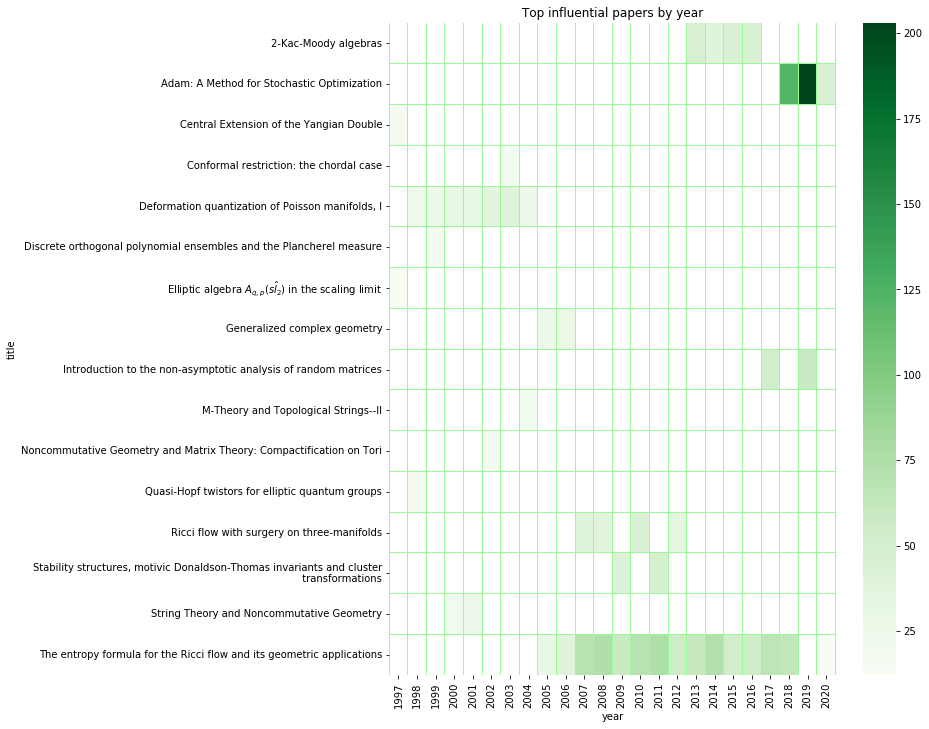

In [197]:
group_name="Mathematics"
cits = top_k_influential (group_name, top_k=2, threshold=10)
show_influential_heatmap (group_name, cits=cits, figsize=(10,12))

In [308]:
#cits.pivot(index="title", columns="year",values="references")

In [309]:
#cits.pivot(index="title", columns="year",values="references").reset_index()

In [307]:
px.defaults.width = 1000
px.defaults.height = 1200
px.defaults.color_continuous_scale  = px.colors.sequential.Greens
fig = px.density_heatmap(cits.pivot(index="title", columns="year",values="references"), template="seaborn")
fig.show()


In [198]:
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}

In [492]:
df_categories = df_categories.drop(index=df_categories[df_categories['id'] == 'astro-ph/0302207'].index[0])
df_papers = df_papers.drop(index=df_papers[df_papers['id'] == 'astro-ph/0302207'].index[0])
df_citations = df_citations.drop(index=df_citations[df_citations['id'] == 'astro-ph/0302207'].index[0])

In [495]:
group_name= ['Physics', 'Mathematics', 'Computer Science',
       'Quantitative Biology', 'Statistics', 'Quantitative Finance',
       'Economics', 'Electrical Engineering and Systems Science']
#group_name = ['Mathematics']
cits = top_k_influential (group_name, top_k=3, threshold=10)

cits['titleSmal'] = cits['title'].str[:30] + " ..."
my_data = cits.pivot(index="titleSmal", columns="year",values="references")
my_data = my_data.fillna(0)

In [498]:
cits

,year,id,references,title,abstract,authors,journal-ref,titleSmal
0,1993,hep-th/9209055,25,Quantum Aspects of Black Holes,This review is based on lectures given at th...,J. A. Harvey and A. Strominger,None,Quantum Aspects of Black Holes ...
1,1993,hep-th/9304011,16,Lectures on 2D gravity and 2D string theory (T...,Emphasis is on 2d target space (c=1 coupled ...,P. Ginsparg and Gregory Moore,None,Lectures on 2D gravity and 2D ...
2,1993,hep-th/9211030,15,Black Hole Remnants and the Information Puzzle,Magnetically charged dilatonic black holes h...,"T. Banks, M. O'Loughlin, and A. Strominger","Phys.Rev.D47:4476-4482,1993",Black Hole Remnants and the In ...
3,1994,hep-th/9309145,24,Some Speculations about Black Hole Entropy in ...,The classical Bekenstein entropy of a black ...,Leonard Susskind,None,Some Speculations about Black ...
4,1994,hep-th/9401139,23,Target Space Duality in String Theory,A review article submitted to Physics Report...,"A. Giveon, M. Porrati and E. Rabinovici","Phys.Rept.244:77-202,1994",Target Space Duality in String ...
...,...,...,...,...,...,...,...,...
78,2018,1412.6980,3092,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Adam: A Method for Stochastic ...
79,2019,1412.6980,4549,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Adam: A Method for Stochastic ...
80,2020,1412.6980,685,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Adam: A Method for Stochastic ...
81,2019,1807.06209,1477,Planck 2018 results. VI. Cosmological parameters,We present cosmological parameter results fr...,"Planck Collaboration: N. Aghanim, Y. Akrami, M...","A&A 641, A6 (2020)",Planck 2018 results. VI. Cosmo ...


In [707]:
import plotly.graph_objects as go

# Simple heatmap example here: https://www.tutorialspoint.com/plotly/plotly_heatmap.htm
# Need to convert a dataframe to lists.
heatmap_data = df_to_plotly(my_data)
titles = cits.groupby('title').first().reset_index()['title'].to_list()
hovertext = list()
for yi, yy in enumerate(titles):
    hovertext.append(list())
    for xi, xx in enumerate(heatmap_data['x']):
        hovertext[-1].append('Year: {}<br />Title: {}<br />Count: {}'.format(xx, yy, heatmap_data['z'][yi][xi]))

# Setting grid lines: https://community.plotly.com/t/grid-lines-placement-in-heatmap/2628/3
heatmap = go.Heatmap(**heatmap_data, type = 'heatmap',colorscale=[[0, "#caf3ff"], [1, "#2c82ff"]], hoverinfo='text', text=hovertext) # xgap=2, ygap=2)
"""lines = go.Scatter(x=[0.5, 1.25, None, 1.65, 1.65],
                   y=[-0.67, -0.67, None, -1,1],
                   mode='lines',
                   line_color='black', line_width=2.5)"""
data = [heatmap]
fig = go.Figure(data=data)

fig.update_layout(
    title=f"Top influential papers in {group_name}",
    font=dict(family="Open Sans"),
    #yaxis_nticks=16,
    #xaxis_nticks=24,
    xaxis=dict(
            ticks="",
            ticklen=2,
            tickfont=dict(family="sans-serif"),
            tickcolor="#ffffff",
    ),
    yaxis=dict(
        side="left", ticks="", tickfont=dict(family="sans-serif"), ticksuffix=" "
    ),)
    #hovermode='y')
fig.show()

**Plot the total publications**

In [320]:
fig = px.line(df, x="month", y="tot", title ="Arxiv preprint counts")
fig.update_layout(width=700,  height=500,)
fig.show()

In [325]:

fig = px.bar(_df, x='id', y='group_name')
fig.update_layout(width=800,  height=600,)
fig.show()


Ideas:
* Optionally, filter by subcategory like computer vision etc.
* Visualize publications in last few years in 2D based on abstracts.

In [9]:
df_versions =  pd.read_csv(project_dir / "data/processed/archive/arxiv-metadata-ext-version.csv",dtype={'id': object})
df_taxonomy = pd.read_csv(project_dir / "data/processed/archive/arxiv-metadata-ext-taxonomy.csv")
df_categories = pd.read_csv(project_dir / "data/processed/archive/arxiv-metadata-ext-category.csv",dtype={'id': object})


In [10]:
df_categories.merge(df_taxonomy, on="category_id")['group_name'].unique()

array(['Physics', 'Mathematics', 'Computer Science',
       'Quantitative Biology', 'Statistics', 'Quantitative Finance',
       'Economics', 'Electrical Engineering and Systems Science'],
      dtype=object)

In [439]:
group_name = ['Physics', 'Mathematics', 'Computer Science',
       'Quantitative Biology', 'Statistics', 'Quantitative Finance',
       'Economics', 'Electrical Engineering and Systems Science']
print(group_name)
if group_name:
    ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name.isin(@group_name)", engine="python")["id"].values
else:
    ids = df_categories.merge(df_taxonomy, on="category_id")["id"].values
#ids = df_versions['id'].values
df = df_versions.query("id.isin(@ids)", engine="python").query("version == 'v1'").groupby(["year","month"]).agg({"id":'count'}).reset_index()

df["tot"] = df["id"].cumsum()

df = df.query("year > 1990 and ( year != 2020 or month < 8)")
df["month"] =  df["year"].astype(str) + "-" + df["month"].astype(str)  

fig = px.line(df, x="month", y="tot", title ="Arxiv preprint counts")
fig.update_layout(width=700,  height=500,)
fig.show()

['Physics', 'Mathematics', 'Computer Science', 'Quantitative Biology', 'Statistics', 'Quantitative Finance', 'Economics', 'Electrical Engineering and Systems Science']


In [497]:
df

,year,month,id,tot
16,1991,1991-1,10,44
17,1991,1991-2,3,47
18,1991,1991-3,3,50
19,1991,1991-4,4,54
20,1991,1991-5,3,57
...,...,...,...,...
382,2021,2021-7,15020,1826835
383,2021,2021-8,13760,1840595
384,2021,2021-9,15303,1855898
385,2021,2021-10,16428,1872326


In [12]:
def preprint_count_df(group_name):
    if not group_name:
            group_name = ['Physics', 'Mathematics', 'Computer Science',
           'Quantitative Biology', 'Statistics', 'Quantitative Finance',
           'Economics', 'Electrical Engineering and Systems Science']
    ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name.isin(@group_name)", engine="python")["id"].values
    
    df = df_versions.query("id.isin(@ids)", engine="python").query("version == 'v1'").groupby(["year","month"]).agg({"id":'count'}).reset_index()

    #df = df.query("year > 1990 and ( year != 2020 or month < 8)")
    #df["month"] =  df["year"].astype(str) + "-" + df["month"].astype(str)  

    return df

In [11]:
def append_group_name(method):
    group_names = ['Physics',
     'Mathematics',
     'Computer Science',
     'Quantitative Biology',
     'Statistics',
     'Quantitative Finance',
     'Economics',
     'Electrical Engineering and Systems Science']
    
    results = []
    for group_name in group_names:
        result_df = method([group_name])
        result_df['group_name'] = group_name
        
        results.append(result_df)
        
    return pd.concat(results, ignore_index=True)

In [501]:
preprint_count_df(group_name)

,year,month,id
16,1991,1991-1,10
17,1991,1991-2,3
18,1991,1991-3,3
19,1991,1991-4,4
20,1991,1991-5,3
...,...,...,...
382,2021,2021-7,15020
383,2021,2021-8,13760
384,2021,2021-9,15303
385,2021,2021-10,16428


In [13]:
my_result = append_group_name(preprint_count_df)
my_result.shape

(2174, 4)

my_result

In [17]:
my_result.head(10)

,year,month,id,group_name
0,1986,4,1,Physics
1,1988,11,1,Physics
2,1990,9,1,Physics
3,1991,8,27,Physics
4,1991,9,59,Physics
5,1991,10,76,Physics
6,1991,11,64,Physics
7,1991,12,76,Physics
8,1992,1,81,Physics
9,1992,2,94,Physics


In [518]:
my_result.groupby(["year","month"]).agg({"id":'sum'}).reset_index()

,year,month,id
0,1991,1,10
1,1991,2,3
2,1991,3,3
3,1991,4,4
4,1991,5,3
...,...,...,...
361,2021,7,18869
362,2021,8,16878
363,2021,9,18942
364,2021,10,20886


In [22]:
my_result.to_csv(project_dir / "data/processed/archive/arxiv-metadata-preprint-count.csv", index=False)

In [20]:
group_name = ['Mathematics' ]#, 'Computer Science']

new_result = my_result[my_result['group_name'].isin(group_name) ].groupby(["year","month"]).agg({"id":'sum'}).reset_index()
new_result["tot"] = new_result["id"].cumsum()
new_result = new_result.query("year > 1990 and ( year != 2020 or month < 8)")
new_result["month"] =  new_result["year"].astype(str) + "-" + new_result["month"].astype(str)  

In [21]:
import plotly.express as px
fig = px.line(new_result, x="month", y="tot", title ="Arxiv preprint counts")
fig.update_layout(width=700,  height=500,)
fig.show()

In [533]:
fig = px.line(df, x="month", y="tot", title ="Arxiv preprint counts")
fig.update_layout(width=700,  height=500,)
fig.show()

In [548]:
group_name = ['Physics', 'Mathematics', 'Computer Science',
'Quantitative Biology', 'Statistics', 'Quantitative Finance',
'Economics', 'Electrical Engineering and Systems Science']
ids = df_categories.merge(df_taxonomy, on="category_id").query("group_name.isin(@group_name)", engine="python")["id"].values

df = df_versions.query("id.isin(@ids)", engine="python").query("version == 'v1'")

In [549]:
df.shape

(1884209, 5)

In [550]:
df.head(10)

,id,version,created,year,month
0,0704.0001,v1,2007-04-02 19:18:42+00:00,2007,4
2,0704.0002,v1,2007-03-31 02:26:18+00:00,2007,3
4,0704.0003,v1,2007-04-01 20:46:54+00:00,2007,4
7,0704.0004,v1,2007-03-31 03:16:14+00:00,2007,3
8,0704.0005,v1,2007-04-02 18:09:58+00:00,2007,4
9,0704.0006,v1,2007-03-31 04:24:59+00:00,2007,3
10,0704.0007,v1,2007-03-31 04:27:22+00:00,2007,3
12,0704.0008,v1,2007-03-31 04:47:20+00:00,2007,3
16,0704.0010,v1,2007-03-31 05:10:16+00:00,2007,3
17,0704.0011,v1,2007-03-31 05:32:49+00:00,2007,3


In [655]:
sec_result = append_group_name(top_k_influential)
sec_result.shape

(247, 8)

In [656]:
sec_result['group_name_uq'] =  sec_result.groupby(['year', 'id'])['group_name'].transform(lambda x: ','.join(x)) 

In [618]:
group_name = ['Mathematics']

In [644]:
sec_result.sample(10)

,year,id,references,title,abstract,authors,journal-ref,group_name,group_name_uq
124,2006,math/0401221,29,Generalized complex geometry,"Generalized complex geometry, as developed b...",Marco Gualtieri,None,Mathematics,Mathematics
152,2019,1412.6980,203,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Mathematics,"Mathematics,Computer Science,Quantitative Biol..."
215,2013,1210.7559,15,Tensor decompositions for learning latent vari...,This work considers a computationally and st...,Anima Anandkumar and Rong Ge and Daniel Hsu an...,"Journal of Machine Learning Research, 15(Aug):...",Statistics,Statistics
207,2019,1312.6114,28,Auto-Encoding Variational Bayes,How can we perform efficient inference and l...,"Diederik P Kingma, Max Welling",None,Quantitative Biology,"Quantitative Biology,Statistics"
77,2017,1405.0301,567,The automated computation of tree-level and ne...,We discuss the theoretical bases that underp...,"J. Alwall, R. Frederix, S. Frixione, V. Hirsch...",JHEP07(2014)079,Physics,Physics
62,2012,1207.7214,475,Observation of a new particle in the search fo...,A search for the Standard Model Higgs boson ...,The ATLAS Collaboration,Phys.Lett. B716 (2012) 1-29,Physics,Physics
186,2017,1412.6980,1487,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Computer Science,"Mathematics,Computer Science,Quantitative Biol..."
190,2016,1512.03385,383,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to...,"Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun",None,Computer Science,"Computer Science,Statistics"
109,2007,math/0211159,70,The entropy formula for the Ricci flow and its...,We present a monotonic expression for the Ri...,Grisha Perelman,None,Mathematics,Mathematics
11,1996,hep-th/9510017,136,Dirichlet-Branes and Ramond-Ramond Charges,"We show that Dirichlet-branes, extended obje...",Joseph Polchinski,"Phys.Rev.Lett.75:4724-4727,1995",Physics,Physics


In [619]:
sec_result_new[sec_result_new.apply(lambda x : any(group in x['group_name_uq'].split(",") for group in group_name),axis = 1)]

,year,id,references,title,group_name_uq
120,2018,1412.6980,122,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
121,2019,1412.6980,203,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
134,2018,1412.6980,2846,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
135,2019,1412.6980,4162,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
153,2018,1412.6980,1056,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
154,2019,1412.6980,1555,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
167,2018,1412.6980,212,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."
168,2019,1412.6980,797,Adam: A Method for Stochastic Optimization,"Mathematics,Computer Science,Statistics,Electr..."


In [588]:
[group in sec_result_new['group_name_uq'].str.split(",") for group in group_name]

[False, False]

In [590]:
cits = sec_result_new[[group in sec_result_new['group_name_uq'].str.split(",") for group in group_name]]

ValueError: Item wrong length 2 instead of 174.

In [646]:
cits

,year,id,references,title,abstract,authors,journal-ref,group_name,group_name_uq,titleSmal
46,2000,hep-th/9908142,259,String Theory and Noncommutative Geometry,We extend earlier ideas about the appearance...,Nathan Seiberg and Edward Witten,"JHEP 9909:032,1999",Physics,"Physics,Mathematics",String Theory and Noncommutati ...
47,2001,hep-th/9908142,275,String Theory and Noncommutative Geometry,We extend earlier ideas about the appearance...,Nathan Seiberg and Edward Witten,"JHEP 9909:032,1999",Physics,"Physics,Mathematics",String Theory and Noncommutati ...
82,2020,1412.6980,75,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Physics,"Physics,Mathematics,Computer Science,Quantitat...",Adam: A Method for Stochastic ...
83,1997,q-alg/9602031,15,Central Extension of the Yangian Double,Central extension $\DYg$ of the Double of th...,S.M. Khoroshkin,None,Mathematics,Mathematics,Central Extension of the Yangi ...
84,1997,q-alg/9702002,12,"Elliptic algebra $A_{q,p}(\hat{sl_2})$ in the ...","The scaling limit $A_{\hbar,\eta}(\hat{sl_2}...","S. Khoroshkin, D. Lebedev, S. Pakuliak",None,Mathematics,Mathematics,"Elliptic algebra $A_{q,p}(\hat ..."
...,...,...,...,...,...,...,...,...,...,...
238,2020,1412.6980,179,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-or...",Diederik P. Kingma and Jimmy Ba,None,Electrical Engineering and Systems Science,"Physics,Mathematics,Computer Science,Quantitat...",Adam: A Method for Stochastic ...
241,2017,1409.1556,12,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Quantitative Biology,Statisti...",Very Deep Convolutional Networ ...
242,2018,1409.1556,91,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Quantitative Biology,Statisti...",Very Deep Convolutional Networ ...
243,2019,1409.1556,391,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Quantitative Biology,Statisti...",Very Deep Convolutional Networ ...


In [672]:
sec_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           247 non-null    int64 
 1   id             247 non-null    object
 2   references     247 non-null    int64 
 3   title          247 non-null    object
 4   abstract       247 non-null    object
 5   authors        247 non-null    object
 6   journal-ref    110 non-null    object
 7   group_name     247 non-null    object
 8   group_name_uq  247 non-null    object
dtypes: int64(2), object(7)
memory usage: 17.5+ KB


In [666]:
sec_result[sec_result['group_name'].isin(group_name) ].groupby(['year', 'id']).agg({"references":'sum'}).reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        106 non-null    int64 
 1   id          106 non-null    object
 2   references  106 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ KB


In [671]:
sec_result['id'] = sec_result['id'].astype('str')

In [674]:
sec_result.merge(sec_result, on='id')

,year_x,id,references_x,title_x,abstract_x,authors_x,journal-ref_x,group_name_x,group_name_uq_x,year_y,references_y,title_y,abstract_y,authors_y,journal-ref_y,group_name_y,group_name_uq_y
0,1993,hep-th/9209055,25,Quantum Aspects of Black Holes,This review is based on lectures given at th...,J. A. Harvey and A. Strominger,None,Physics,Physics,1993,25,Quantum Aspects of Black Holes,This review is based on lectures given at th...,J. A. Harvey and A. Strominger,None,Physics,Physics
1,1993,hep-th/9304011,16,Lectures on 2D gravity and 2D string theory (T...,Emphasis is on 2d target space (c=1 coupled ...,P. Ginsparg and Gregory Moore,None,Physics,Physics,1993,16,Lectures on 2D gravity and 2D string theory (T...,Emphasis is on 2d target space (c=1 coupled ...,P. Ginsparg and Gregory Moore,None,Physics,Physics
2,1993,hep-th/9211030,15,Black Hole Remnants and the Information Puzzle,Magnetically charged dilatonic black holes h...,"T. Banks, M. O'Loughlin, and A. Strominger","Phys.Rev.D47:4476-4482,1993",Physics,Physics,1993,15,Black Hole Remnants and the Information Puzzle,Magnetically charged dilatonic black holes h...,"T. Banks, M. O'Loughlin, and A. Strominger","Phys.Rev.D47:4476-4482,1993",Physics,Physics
3,1994,hep-th/9309145,24,Some Speculations about Black Hole Entropy in ...,The classical Bekenstein entropy of a black ...,Leonard Susskind,None,Physics,Physics,1994,24,Some Speculations about Black Hole Entropy in ...,The classical Bekenstein entropy of a black ...,Leonard Susskind,None,Physics,Physics
4,1994,hep-th/9401139,23,Target Space Duality in String Theory,A review article submitted to Physics Report...,"A. Giveon, M. Porrati and E. Rabinovici","Phys.Rept.244:77-202,1994",Physics,Physics,1994,23,Target Space Duality in String Theory,A review article submitted to Physics Report...,"A. Giveon, M. Porrati and E. Rabinovici","Phys.Rept.244:77-202,1994",Physics,Physics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,2018,1609.03499,92,WaveNet: A Generative Model for Raw Audio,"This paper introduces WaveNet, a deep neural...","Aaron van den Oord, Sander Dieleman, Heiga Zen...",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,2018,92,WaveNet: A Generative Model for Raw Audio,"This paper introduces WaveNet, a deep neural...","Aaron van den Oord, Sander Dieleman, Heiga Zen...",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science
2301,2019,1502.03167,224,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,2019,224,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science
2302,2019,1502.03167,224,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,2020,48,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science
2303,2020,1502.03167,48,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science,2019,224,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science


In [683]:
sec_result[sec_result['group_name'].isin(group_name) ].groupby(['year', 'id']).agg({"references":'sum'}).reset_index().head(20)

,year,id,references
0,1997,q-alg/9602031,15
1,1997,q-alg/9702002,12
2,1998,hep-th/9711162,11
3,1998,q-alg/9709040,22
4,1998,q-alg/9712029,15
5,1999,math/9903176,16
6,1999,math/9906120,17
7,1999,q-alg/9709040,25
8,2000,cs/0010035,14
9,2000,hep-th/9606040,18


In [697]:
sec_result[sec_result['group_name'].isin(group_name) ].groupby(['year', 'id']).agg({"references":'sum'}).reset_index().shape

(106, 3)

In [684]:
sec_result.merge?

In [702]:
sec_result

,year,id,references,title,abstract,authors,journal-ref,group_name,group_name_uq
0,1993,hep-th/9209055,25,Quantum Aspects of Black Holes,This review is based on lectures given at th...,J. A. Harvey and A. Strominger,None,Physics,Physics
1,1993,hep-th/9304011,16,Lectures on 2D gravity and 2D string theory (T...,Emphasis is on 2d target space (c=1 coupled ...,P. Ginsparg and Gregory Moore,None,Physics,Physics
2,1993,hep-th/9211030,15,Black Hole Remnants and the Information Puzzle,Magnetically charged dilatonic black holes h...,"T. Banks, M. O'Loughlin, and A. Strominger","Phys.Rev.D47:4476-4482,1993",Physics,Physics
3,1994,hep-th/9309145,24,Some Speculations about Black Hole Entropy in ...,The classical Bekenstein entropy of a black ...,Leonard Susskind,None,Physics,Physics
4,1994,hep-th/9401139,23,Target Space Duality in String Theory,A review article submitted to Physics Report...,"A. Giveon, M. Porrati and E. Rabinovici","Phys.Rept.244:77-202,1994",Physics,Physics
...,...,...,...,...,...,...,...,...,...
242,2018,1409.1556,91,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Quantitative Biology,Statisti..."
243,2019,1409.1556,391,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Quantitative Biology,Statisti..."
244,2020,1409.1556,76,Very Deep Convolutional Networks for Large-Sca...,In this work we investigate the effect of th...,"Karen Simonyan, Andrew Zisserman",None,Electrical Engineering and Systems Science,"Computer Science,Electrical Engineering and Sy..."
245,2019,1502.03167,224,Batch Normalization: Accelerating Deep Network...,Training Deep Neural Networks is complicated...,"Sergey Ioffe, Christian Szegedy",None,Electrical Engineering and Systems Science,Electrical Engineering and Systems Science


In [703]:
group_name = ['Mathematics', 'Computer Science']
result_set = sec_result[sec_result['group_name'].isin(group_name) ].groupby(['year', 'id']).agg({"references":'sum', "title" : 'first'}).reset_index()
result_set

,year,id,references,title
0,1997,q-alg/9602031,15,Central Extension of the Yangian Double
1,1997,q-alg/9702002,12,"Elliptic algebra $A_{q,p}(\hat{sl_2})$ in the ..."
2,1998,hep-th/9711162,11,Noncommutative Geometry and Matrix Theory: Com...
3,1998,q-alg/9709040,22,"Deformation quantization of Poisson manifolds, I"
4,1998,q-alg/9712029,15,Quasi-Hopf twistors for elliptic quantum groups
...,...,...,...,...
101,2020,1011.3027,11,Introduction to the non-asymptotic analysis of...
102,2020,1409.1556,273,Very Deep Convolutional Networks for Large-Sca...
103,2020,1412.6980,662,Adam: A Method for Stochastic Optimization
104,2020,1810.04805,190,BERT: Pre-training of Deep Bidirectional Trans...


In [713]:
sec_result.to_csv((project_dir / "data/raw/archive/arxiv-metadata-influential.csv"), index=False)

In [715]:
_df.to_csv((project_dir / "data/raw/archive/arxiv-group-count.csv"), index=False)

In [706]:
group_name= ['Mathematics', 'Computer Science']
#group_name = ['Mathematics']
cits = sec_result[sec_result['group_name'].isin(group_name) ].groupby(['year', 'id']).agg({"references":'sum', "title" : 'first'}).reset_index() #top_k_influential (group_name, top_k=3, threshold=10)
#cits = sec_result[sec_result['group_name'] == 'Mathematics']

cits['titleSmal'] = cits['title'].str[:30] + " ..."
my_data = cits.pivot(index="titleSmal", columns="year",values="references")
my_data = my_data.fillna(0)